In [18]:
#! Credit to Vadim for code

In [19]:
import eazy, os

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from math import ceil, floor
from copy import deepcopy as copy

from astropy import units as u
from astropy.cosmology import Planck18
from astropy.io import fits
from astropy.table import Table, join, hstack
from astropy.visualization import ZScaleInterval as zs
from astroquery.mast import Observations as obs
from IPython.utils import io
from matplotlib.transforms import Affine2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import eazy_routines as ez
import helper_module as hmod

if not os.path.exists('templates'):
    eazy.symlink_eazy_inputs()

cosmo = Planck18


### Load JADES photometry

... and make an EAZY catalog of it.

In [20]:
# log all camera filters
flt = eazy.filters.FilterFile()

filts_nircam = {
        'F090W': 363,
        'F115W': 364,
        'F150W': 365,
        'F182M': 370,
        'F200W': 366,
        'F210M': 371,
        'F277W': 375,
        'F335M': 381,
        'F356W': 376,
        'F410M': 383,
        'F430M': 384,
        'F444W': 358,
        'F460M': 385,
        'F480M': 386
}

filts_HST = {
        'F105W': 202,
        'F125W': 203,
        'F140W': 204,
        'F160W': 205,
        'F435W': 233,
        'F606W': 214,
        'F775W': 216,
        'F814W': 239,
        'F850LP': 240
}

filts = {**filts_nircam, **filts_HST}

mw_reddening = ez.get_atten_dict(filts)

# get zeropoints
zps = [1.0]*len(filts)

In [21]:
#=== load data
#inname = "hlsp_jades_jwst_nircam_goods-s-deep_photometry_v1.0_catalog.fits"
inname = "hlsp_jades_jwst_nircam_goods-s-deep_photometry_v1.0_catalog_large_withSpec.fits"
inpath = os.path.join(os.getenv('astrodata'), 'gds/jades/phot', inname)

# print the meta info
with fits.open(inpath) as hdul:
    print(hdul.info())

# load photometry table
tab = Table.read(inpath, hdu=6)
tab_redshifts = Table.read(inpath, hdu=9)

#=== make EAZY table

# load fluxes
# CIRC1: 0.10 arcsec aperture (see README)
ext = '_CIRC1'
cols_fluxes = hmod.get_matches(ext, tab.columns, exclude='_ei')
cols_f = np.sort(hmod.get_matches(ext, cols_fluxes, exclude='_e'))
cols_fe = np.sort(hmod.get_matches('_e', cols_fluxes))
cols_fluxes = list(np.vstack([cols_f, cols_fe]).T.flatten())
cols = list(np.insert(cols_fluxes, 0, ['ID', 'RA', 'DEC', 'z_spec']))

tab = join(tab, tab_redshifts['ID', 'z_spec'], join_type='inner', keys='ID')
tab_out = tab[cols]

# convert from nJy to uJy
# and apply MW reddening
keys = np.array(list(mw_reddening.keys()))
for c in cols_fluxes:
    tab_out[c].unit = u.nJy
    tab_out[c] = tab_out[c].to(u.uJy)
    
    # apply MW reddening
    matches = hmod.get_matches(keys, c, get_idxs=True)
    key = keys[np.int32(matches[:,0])][0]
    tab_out[c] *= mw_reddening[key]
    
# rename columns
for c in cols_f:
    cnew = c.replace(ext, '_flux')
    tab_out.rename_column(c, cnew)

for c in cols_fe:
    cnew = c.replace(ext+'_e', '_err')
    tab_out.rename_column(c, cnew)

#=== apply MW reddening
#atten_dict = ez.get_atten_dict(filts_eazyres, filts_str)
#degr_image_sig *= atten_dict[filt] / 100. # uJy

# save EAZY table
tab_out.write('./data/gds_jades_eazy.fits', format='fits', overwrite=True)

Filename: /home/t/astrodata/gds/jades/phot/hlsp_jades_jwst_nircam_goods-s-deep_photometry_v1.0_catalog_large_withSpec.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      13   ()      
  1  FILTERS       1 BinTableHDU     33   23R x 12C   [6A, E, E, E, E, E, E, E, E, E, E, E]   
  2  FLAG          1 BinTableHDU    161   1429R x 75C   [J, D, D, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, I, E, E]   
  3  SIZE          1 BinTableHDU    100   1429R x 43C   [J, D, D, E, D, D, D, D, J, J, J, J, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E]   
  4  CIRC          1 BinTableHDU    856   1429R x 423C   [J, D, D, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E,

### Fit templates

In [22]:
runTime = int(time.time())

In [23]:
#=== set up paths for eazy

# catalog paths
cat_name = 'gds_jades_eazy'
cat_path = f'./data/{cat_name}.fits'
keys_id = ['ID id', 'RA ra', 'DEC dec', 'z_spec z_spec']

# template names and paths
"""ftempl_strs = ['corr_sfhz_13', 'blue_sfhz_13', 'fsps_45k']"""
"""templ_paths = [f"templates/sfhz/{ftempl_strs[0]}.param",
               f"templates/sfhz/{ftempl_strs[1]}.param",
               f"templates/templates-c2020/45k/{ftempl_strs[2]}.param"]"""
ftempl_strs = [
    'templates-custom/45k/optimized_45k'
    'fsps_45k_0.3removed',
    'fsps_45k',
    'fsps_60k',
    'carnall_sfhz_13',
    'corr_sfhz_13',
    'blue_sfhz_13',
    'eazy_v1.1_lines.spectra', 
    'eazy_v1.3.spectra',
    'br07_default.spectra',
    #'pegase.spectra',
    'pegase13.spectra',
    #'cww+kin.spectra'
    ]
templ_paths = [f"templates/{e}.param" for e in ftempl_strs]
out_names = [".".join(f.split('/')[-1].split(".")[:-1]) for f in templ_paths]
out_paths = [f"eazy-output/{f}_{runTime}" for f in out_names]
paths = np.array([templ_paths, out_paths]).T

In [24]:
# iterate over tempalte sets
for tpath, opath in paths:
    
    params = {"cat_path": cat_path,
              "templ_path": tpath,
              "out_path": opath,
              "FIX_ZSPEC": 'n',
              "USE_ZSPEC_FOR_REST": 'n',
              "Z_MAX": 12.0,
              "H0": cosmo.H0,
              "OMEGA_M": cosmo.Om0,
              "OMEGA_L": cosmo.Ode0,
              "CATALOG_FORMAT": 'fits'}
    
    # write eazy config files
    filt_num, fnames = ez.write_config(cat_name, filts, zps, keys_id,
                                       out_path=opath)

    # run eazy
    #idx = np.array([0])
    idx = None
    zout, hdu = ez.run_eazy(params, fnames, n_proc=-1, idx=idx)

Read default param file: /home/t/miniconda3/envs/eazy39/lib/python3.9/site-packages/eazy/data/zphot.param.default
Read CATALOG_FILE: ./data/gds_jades_eazy.fits
   >>> NOBJ = 1429
F090W_flux F090W_err (363): jwst_nircam_f090w
F115W_flux F115W_err (364): jwst_nircam_f115w
F150W_flux F150W_err (365): jwst_nircam_f150w
F182M_flux F182M_err (370): jwst_nircam_f182m
F200W_flux F200W_err (366): jwst_nircam_f200w
F210M_flux F210M_err (371): jwst_nircam_f210m
F277W_flux F277W_err (375): jwst_nircam_f277w
F335M_flux F335M_err (381): jwst_nircam_f335m
F356W_flux F356W_err (376): jwst_nircam_f356w
F410M_flux F410M_err (383): jwst_nircam_f410m
F430M_flux F430M_err (384): jwst_nircam_f430m
F444W_flux F444W_err (358): jwst_niriss_f444w
F460M_flux F460M_err (385): jwst_nircam_f460m
F480M_flux F480M_err (386): jwst_nircam_f480m
F105W_flux F105W_err (202): hst/wfc3/IR/f105w.dat
F125W_flux F125W_err (203): hst/wfc3/IR/f125w.dat
F140W_flux F140W_err (204): hst/wfc3/IR/f140w.dat
F160W_flux F160W_err (205):

100%|██████████| 4/4 [00:04<00:00,  1.07s/it]


Template   0: fsps_45k_t0.1_Av0.0.fits (NZ=1).
Template   1: fsps_45k_t0.1_Av0.5.fits (NZ=1).
Template   2: fsps_45k_t0.5_Av0.0.fits (NZ=1).
Template   3: fsps_45k_t0.5_Av0.5.fits (NZ=1).
Process templates: 5.210 s


256it [00:00, 819.70it/s]
100%|██████████| 256/256 [00:10<00:00, 24.67it/s]


Compute best fits
fit_best: 0.4 s (n_proc=1,  NOBJ=1415)
Fit 10.9 s (n_proc=8, NOBJ=1429)
Get best fit coeffs & best redshifts
fit_best: 1.6 s (n_proc=1,  NOBJ=1415)
Get parameters (UBVJ=[153, 154, 155, 161], simple=False)


100%|██████████| 1415/1415 [00:12<00:00, 110.00it/s]


 25%|██▌       | 354/1415 [00:10<00:31, 34.02it/s]


KeyboardInterrupt: 

### Compare results with the spectra

Load best-fit properties by templates:

In [29]:
#find latest runTime in folder:
runTime = int(np.sort([int(f.split('_')[-1]) for f in os.listdir('eazy-output')])[-1])
outpaths = 'eazy-output/{ftempl}_{runTime}/gds_jades_eazy.zout.fits'

Load spectra:

In [30]:
#=== load EAZY outputs
fpath = 'eazy-output/{ftempl}_{runTime}/gds_jades_eazy.zout.fits'
ftempl = ftempl_strs[0]
fpath = fpath.format(ftempl=ftempl, runTime=runTime)
tbl = Table.read(fpath)
names = [name for name in tbl.colnames if len(tbl[name].shape) <= 1]
df = tbl[names].to_pandas()
#change df 'id' to 'ID'
df.rename(columns={'id': 'ID'}, inplace=True)

fname = "hlsp_jades_jwst_nircam_goods-s-deep_photometry_v1.0_catalog.fits"
fpath = os.path.join(os.getenv('astrodata'), 'gds/jades/phot', fname)
tbl = Table.read(fpath, hdu=9)
names = [name for name in tbl.colnames if len(tbl[name].shape) <= 1]
names = [name for name in names if 
    'ID' in name or
    'EAZY_z_a' in name or 
    'z_spec_source' in name or 
    'z_spec_quality' in name or
    'z_spec_reference' in name
]
df_spec = tbl[names].to_pandas()

# add spec info to the photo table
df = pd.merge(df, df_spec, on='ID', how='left')

#=== create masks
masks = {}
masks['z_spec'] = ~df['z_spec'].isna()

for i, (k, m) in enumerate(masks.items()):
    if isinstance(m, pd.Series):
        masks[k] = m.values

Redshift cross-check:

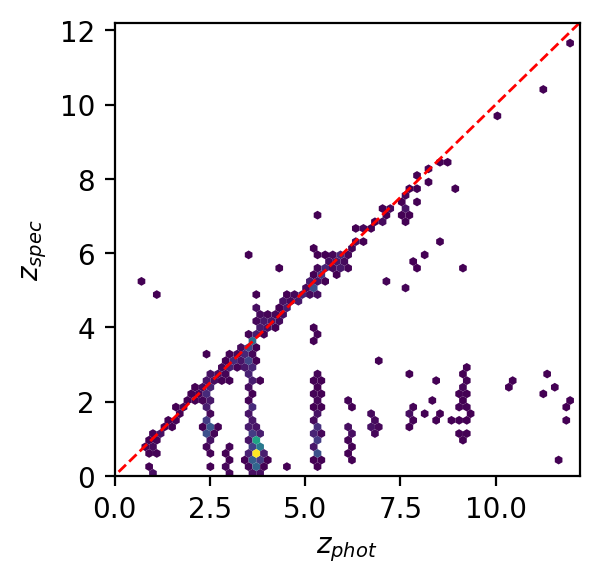

In [31]:
mask_cur = masks['z_spec']

x = df['z_spec'].values[mask_cur]
y = df['z_phot'].values[mask_cur]

xmin, xmax = np.c_[x, y].min(), np.c_[x, y].max()
dx, dy = 0.2, 0.35

gridsize = (int((xmax-xmin)/dx), 
            int((xmax-xmin)/dy))

fig, ax = plt.subplots(1, figsize=(3, 3), dpi=200)
ax.set_xlabel('$z_{phot}$')
ax.set_ylabel('$z_{spec}$')
ax.set_xlim(0, 12.2)
ax.set_ylim(0.0, 12.2)

ax.hexbin(y, x, gridsize=gridsize,
          extent=(xmin, xmax, xmin, xmax), mincnt=1,
          edgecolors='none')
ax.plot([xmin, xmax], [xmin, xmax], ls='--', c='r', lw=1.0)
plt.show()

Plot spectra and best-fit SEDs:

In [32]:
# catalog paths
cat_name = 'gds_jades_eazy'
cat_path = f'./data/{cat_name}.fits'
keys_id = ['ID id', 'RA ra', 'DEC dec', 'z_spec z_spec']

# template paths
"""templ_paths = ["templates/sfhz/corr_sfhz_13.param",
               "templates/sfhz/blue_sfhz_13.param",
               "templates/templates-c2020/45k/fsps_45k.param"]"""
"""out_names = [f.split('/')[-1].split('.')[0] for f in templ_paths]
out_paths = [f"eazy-output/{f}" for f in out_names]"""
out_paths = ["_".join(p.split('_')[:-1]) + f"_{runTime}" for p in out_paths]
paths = np.array([templ_paths, out_paths]).T

# iterate over tempalte sets
for tpath, opath in paths[:1]:
    
    params = {"cat_path": cat_path,
              "templ_path": tpath,
              "out_path": opath,
              "FIX_ZSPEC": 'n',
              "USE_ZSPEC_FOR_REST": 'n',
              "Z_MAX": 12.0,
              "H0": cosmo.H0,
              "OMEGA_M": cosmo.Om0,
              "OMEGA_L": cosmo.Ode0,
              "CATALOG_FORMAT": 'fits',
              'VERBOSE': 'n'}
    
    # write eazy config files
    filt_num, fnames = ez.write_config(cat_name, filts, zps, keys_id,
                                       out_path=opath, fwrite=False)
    
    # get a photoz object
    with io.capture_output() as captured: # capture output
        pz = ez.eazy_init_photoz(params, **fnames)

In [33]:
# get best-fit redshifts and add to the catalog
tab_zbest = Table.from_pandas(df[['ID', 'z_phot', 'z_phot_risk']])
zbest = join(pz.cat[['ID']], tab_zbest, 
             keys='ID', join_type='left')

# get best-fit templates at zbest
#pz.fit_at_zbest(zbest=zbest)

Load RA & DEC of spectra. Then, match with the photometry catalog:

In [34]:
from astropy.coordinates import SkyCoord

def match_catalogs(samp_x, samp_y, cat_x, cat_y, max_sep=1.0*u.arcsec):
    sample = SkyCoord(ra=samp_x*u.degree, dec=samp_y*u.degree)
    catalog = SkyCoord(ra=cat_x*u.degree, dec=cat_y*u.degree)
    idx, d2d, d3d = sample.match_to_catalog_sky(catalog)
    samp_sel = d2d < max_sep
    return samp_sel, idx

#=== load meta data from spec files
dname = "hlsp_jades_jwst_nirspec_goods-s-deephst_clear-prism_v1.0"
fpath = os.path.join(os.getenv('astrodata'), 'gds/jades/spec', dname)

fnames_1d = [f for f in os.listdir(fpath) if '_x1d.fits' in f]
fpaths_1d = np.sort([os.path.join(fpath, f) for f in fnames_1d])

# get RA and DEC from the 1D spectra headers
df_spec = pd.DataFrame(columns=['ID', 'RA', 'DEC'], dtype=np.float32)
spec_data = {}
for f in fpaths_1d:
    id_fname = int(f.split('/')[-1].split('-')[3].strip('_clear'))
    with fits.open(f) as hdul:
        hdr = hdul[0].header
        row = np.array([id_fname, hdr['RA'], hdr['DEC']]).reshape(1, -1)
        df_cur = pd.DataFrame(row, columns=['ID', 'RA', 'DEC'])
        df_spec = pd.concat([df_spec, df_cur])
        
        
        unit = u.Unit(hdr['BUNIT']) # erg/s/cm2/A
        flux = hdul[1].data['FLUX'] * unit
        fluxerr = hdul[1].data['FLUX_ERR'] * unit
        wave = hdul[1].data['WAVELENGTH'] * u.um
        equiv = u.spectral_density(wave.to(u.AA))
        flux = flux.to(unit * u.AA / u.Hz, equivalencies=equiv)
        fluxerr = fluxerr.to(unit * u.AA / u.Hz, equivalencies=equiv)
        spec_data[id_fname] = [wave.value, 
                               flux.to(u.uJy).value, 
                               fluxerr.to(u.uJy).value]
        #spec_data[id_fname] = hdul[1].data['FLUX']
        

df_spec.reset_index(drop=True, inplace=True)
df_spec.ID = df_spec.ID.astype(np.int32)

#===match catalogs

# match spec sample to photo catalog
cat_x = df['ra'].values
cat_y = df['dec'].values
samp_x = df_spec['RA'].values
samp_y = df_spec['DEC'].values
mask_samp, idx_cat = match_catalogs(samp_x, samp_y, cat_x, cat_y, 
                                    max_sep=0.8*u.arcsec)

# add spec-flag column to catalog
df['ID_spec'] = np.nan
df.loc[idx_cat[mask_samp], 'ID_spec'] = df_spec.loc[mask_samp, 'ID'].values

In [35]:
#=== rebin spectrum

from astropy import units as u

#x = wave
#y = flux_floor
#ye = flux_floor_err

def rebin_spec(x, y, ye, xlo=None, xhi=None, bw=1):
    """ 
    Rebin the spectrum to get higher SN
    """
    from spectres import spectres
    x_new = np.arange(xlo+bw, xhi, bw)
    y_new, ye_new = spectres(x_new, x, y, spec_errs=ye)
    return x_new, y_new, ye_new

def plot_binned_spec(x, y, ye, x_new, y_new, ye_new):
    
    axs = plt.figure(figsize=(5, 5), dpi=100).subplot_mosaic(
        """
        a
        b
        c
        """,
        gridspec_kw={
            "height_ratios": [3, 1, 1],
            "hspace": 0.0
        }
    )

    axs['a'].step(x, y, label='original') # original binning
    axs['a'].step(x_new, y_new, label='rebinned') # original binning
    axs['a'].set_ylabel('f')
    axs['a'].set_ylim(0.0, 0.05)
    axs['a'].set_xticklabels([])
    axs['a'].legend()
    axs['b'].step(x, y/ye)
    axs['b'].step(x_new, y_new / ye_new)
    axs['b'].set_ylabel('SNR')
    axs['b'].set_ylim(0.0, 10)
    axs['c'].step(x, ye)
    axs['c'].step(x_new, ye_new)
    axs['c'].set_ylabel('$\Delta$f')
    axs['c'].set_ylim(0.0, 0.05)

    plt.show()
    return 

#spaxel_lam_orig = (wave.max() - wave.min()) / 1024
#spaxel_lam_rbin = (wave.max() - wave.min()) / 1024 * bw
#print(f"original spectrum: 1 spaxel = {spaxel_lam_orig:.2f} A")
#print(f"rebinned spectrum: 1 spaxel = {spaxel_lam_rbin:.2f} A, bw={bw:.1f} A")

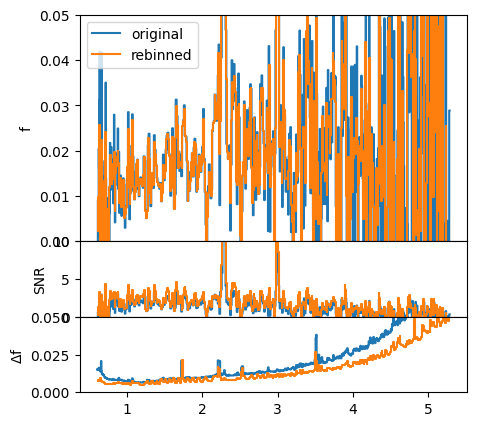

In [36]:
x = spec_data[2651][0]
y = spec_data[2651][1]
ye = spec_data[2651][2]
xbin, ybin, yebin = rebin_spec(x, y, ye, xlo=x.min(), xhi=x.max(), bw=0.01)
plot_binned_spec(x, y, ye, xbin, ybin, yebin)

### Plot spectra and SEDs

In [37]:
def obs2local(wave, flux, fluxerr, z, zerr=0):
    """
    Convert observed-frame fluxes to rest-frame
    """
    wave, flux, fluxerr = np.array(wave), np.array(flux), np.array(fluxerr)
    wave_rest = wave / (1 + z)
    #flux_rest = flux * (1 + z)
    #fluxerr_rest = np.sqrt((fluxerr * (1 + z))**2 + (flux * zerr)**2)
    return wave_rest, flux, fluxerr
    return wave_rest, flux_rest, fluxerr_rest

from scipy.interpolate import interp1d

def scale2MinimizeChi2(func1,func2):#! not tested
    """
    Scale func2 to minimize chi2 between func1 and func2
    """
    #from solve algebra, one can find that the solution is given by:
    #Sum{func1*func2}=scale*Sum{func2*func2}
    #scale=Sum{func1*func2}/Sum{func2*func2}
    
    func1_xs = func1[0]
    func1_ys = func1[1]
    func2_xs = func2[0]
    func2_ys = func2[1]

    #remove nans in func1
    notNanMask = np.invert(np.isnan(func1_ys))
    func1_xs = func1_xs[notNanMask]
    func1_ys = func1_ys[notNanMask]

    #remove nans in func2
    notNanMask = np.invert(np.isnan(func2_ys))
    func2_xs = func2_xs[notNanMask]
    func2_ys = func2_ys[notNanMask]

    #cut func2 to the same range as func1
    mask = (func2_xs>=func1_xs.min())&(func2_xs<=func1_xs.max())
    func2_xs = func2_xs[mask]
    func2_ys = func2_ys[mask]

    #cut func1 to the same range as func2
    mask = (func1_xs>=func2_xs.min())&(func1_xs<=func2_xs.max())
    func1_xs = func1_xs[mask]
    func1_ys = func1_ys[mask]

    #append ends to func1 and func2 with same x
    if func1_xs.min()<func2_xs.min():
        func2_xs = np.array([func1_xs.min()]+list(func2_xs))
        func2_ys = np.array([func2_ys[0]]+list(func2_ys))
    elif func2_xs.min()<func1_xs.min():
        func1_xs = np.array([func2_xs.min()]+list(func1_xs))
        func1_ys = np.array([func1_ys[0]]+list(func1_ys))
    if func1_xs.max()>func2_xs.max():
        func2_xs = np.array(list(func2_xs)+[func1_xs.max()])
        func2_ys = np.array(list(func2_ys)+[func2_ys[-1]])
    elif func2_xs.max()>func1_xs.max():
        func1_xs = np.array(list(func1_xs)+[func2_xs.max()])
        func1_ys = np.array(list(func1_ys)+[func1_ys[-1]])

    #use interpolation to find values of func2 at func1_xs and vice versa
    def interpolate(x,y,xs):
        f = interp1d(x,y)
        return f(xs)
    func1_ys_at_func2_xs = interpolate(func1_xs,func1_ys,func2_xs)
    func2_ys_at_func1_xs = interpolate(func2_xs,func2_ys,func1_xs)
    #interweve the interpolations to create new functions
    X = np.concatenate((func1_xs,func2_xs))
    order = np.argsort(X)
    X = X[order]
    Y_func1 = np.concatenate((func1_ys,func1_ys_at_func2_xs))
    Y_func2 = np.concatenate((func2_ys_at_func1_xs,func2_ys))
    Y_func1 = Y_func1[order]
    Y_func2 = Y_func2[order]

    #calculate sums
    sum_func1_func2 = np.sum(Y_func1*Y_func2)
    sum_func2_func2 = np.sum(Y_func2*Y_func2)

    #calculate scale
    scale = sum_func1_func2/sum_func2_func2

    #return scale
    return scale 

Objects:  dict_keys([2528, 2651, 2773, 2923, 3137, 3184, 3321, 3322, 3334, 3473, 3520, 3753, 3803, 3892, 3968, 4009, 4168, 4270, 4282, 4297, 4394, 4404, 4413, 4493, 4668, 4902, 4950, 5040, 5076, 5320, 5329, 5457, 5686, 5759, 5825, 6002, 6246, 6268, 6349, 6384, 6438, 6460, 6519, 6710, 6855, 7099, 7304, 7507, 7624, 7629, 7762, 7809, 7892, 7938, 8013, 8073, 8079, 8083, 8102, 8113, 8115, 8245, 8456, 8718, 8784, 8880, 8891, 8896, 9343, 9422, 9452, 9743, 9992, 10040, 10073, 16478, 16625, 16745, 16996, 17072, 17160, 17251, 17260, 17400, 17435, 17566, 17670, 17777, 17824, 17832, 18028, 18090, 18179, 18322, 18846, 18970, 18976, 19175, 19342, 19431, 19519, 19606, 19607, 19782, 20313, 20961, 20962, 21150, 21598, 21842, 22078, 22251, 22924, 10000081, 10000483, 10000626, 10001587, 10001761, 10001892, 10001916, 10003811, 10004819, 10005113, 10005447, 10008722, 10009320, 10009506, 10009693, 10010639, 10010642, 10010691, 10010770, 10011378, 10013545, 10013682, 10013704, 10014177, 10014220, 10035295, 1

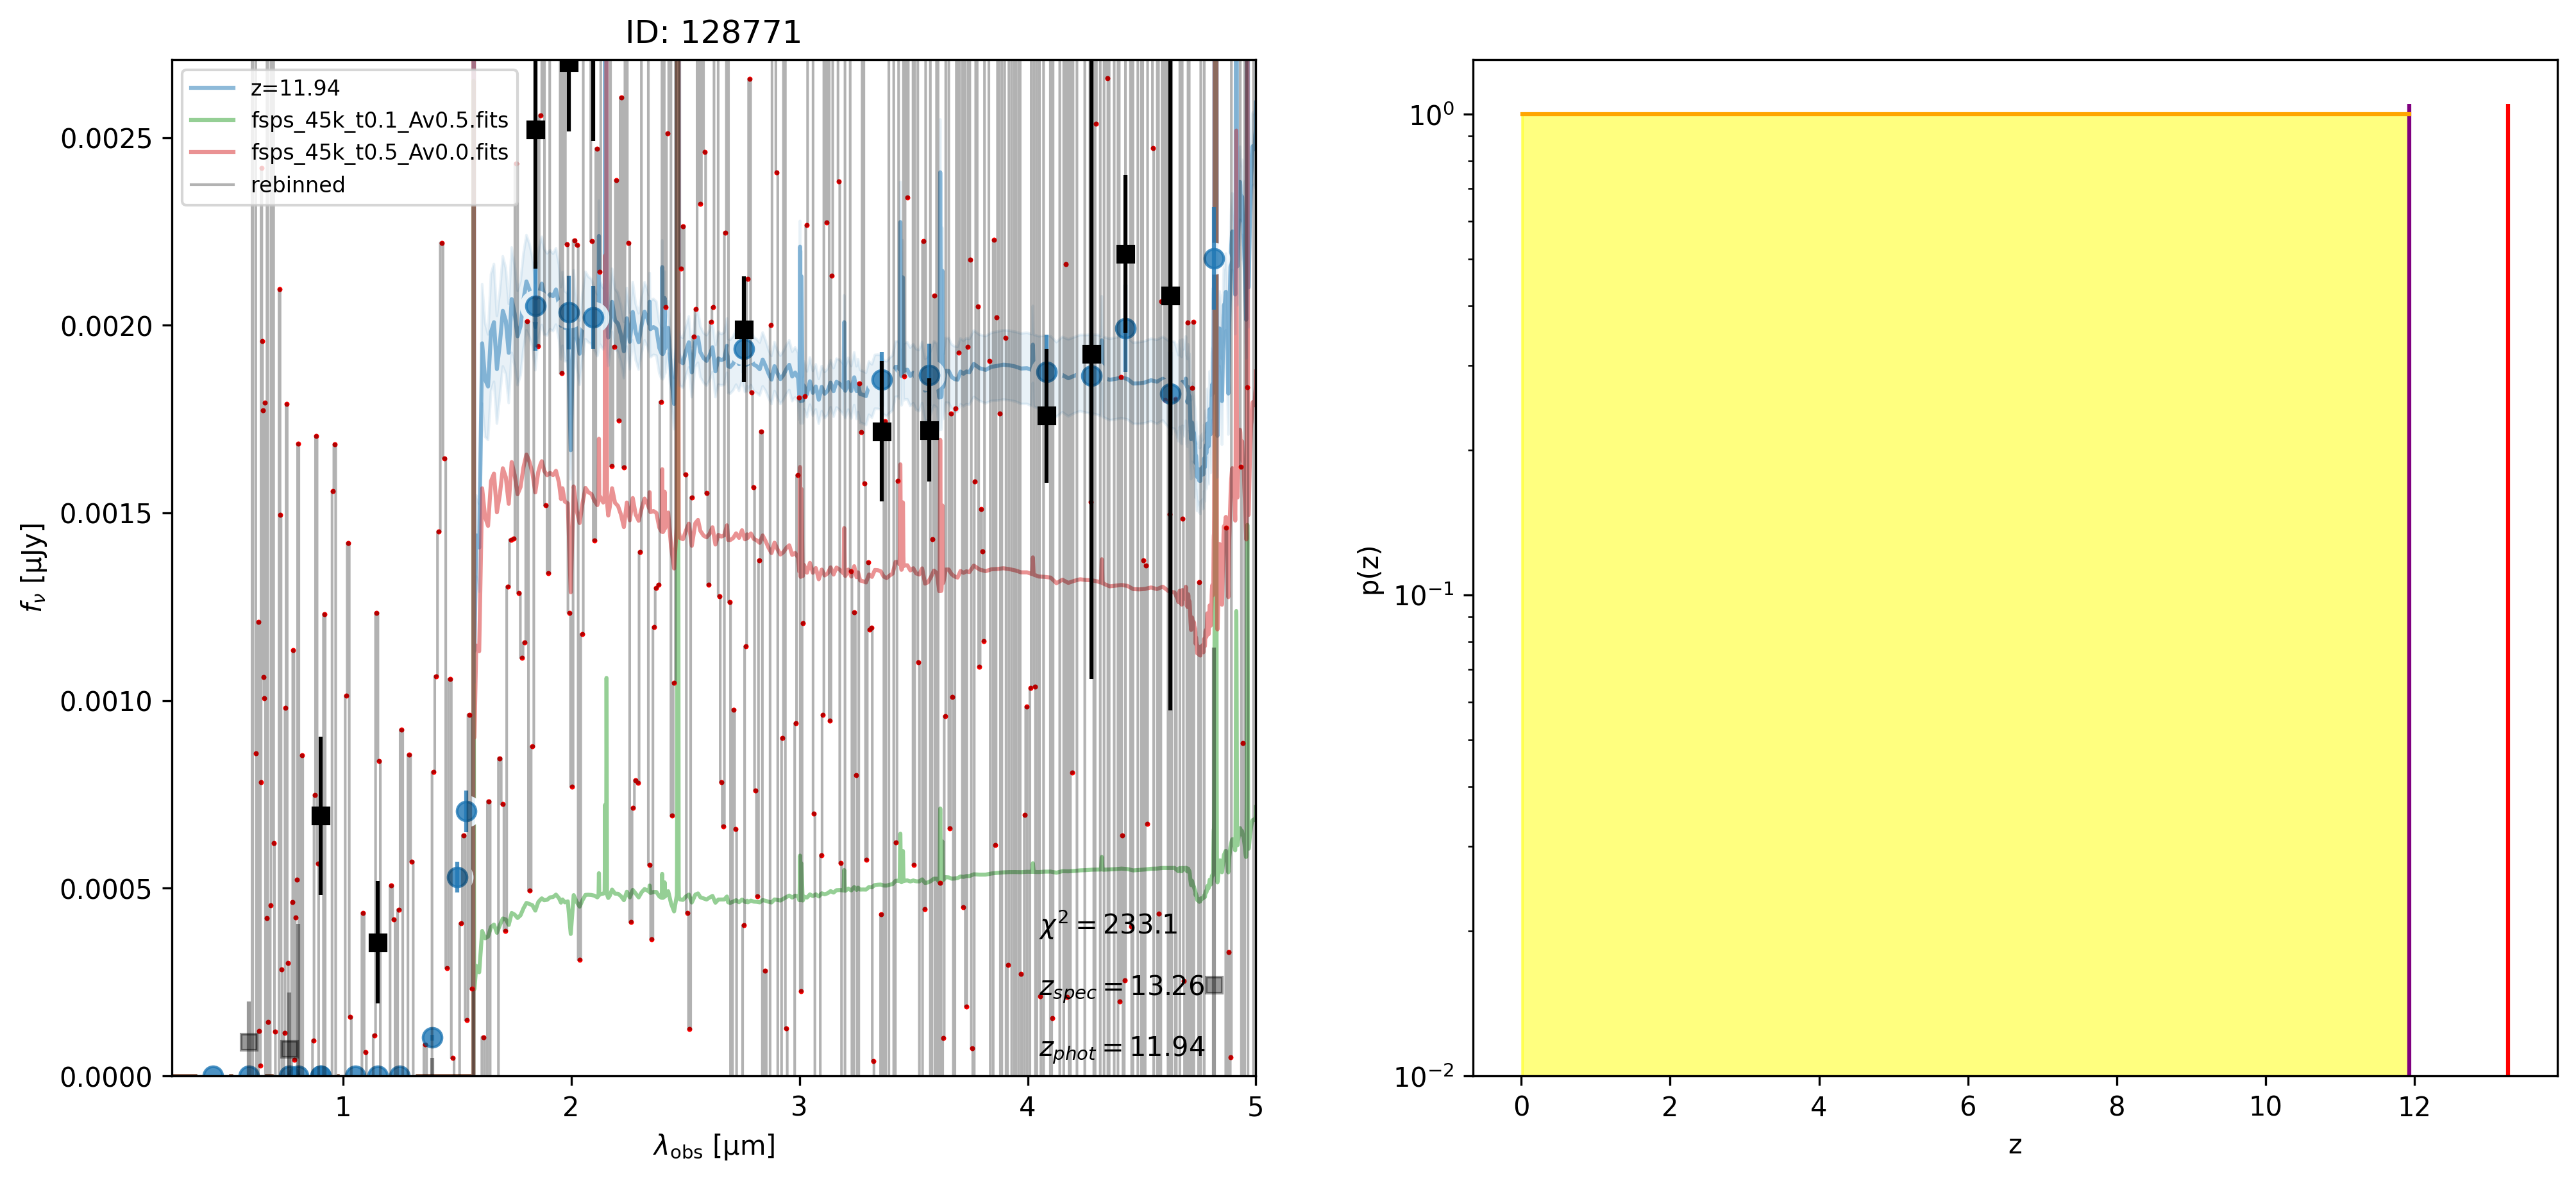

/home/t/miniconda3/envs/eazy39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/t/miniconda3/envs/eazy39/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


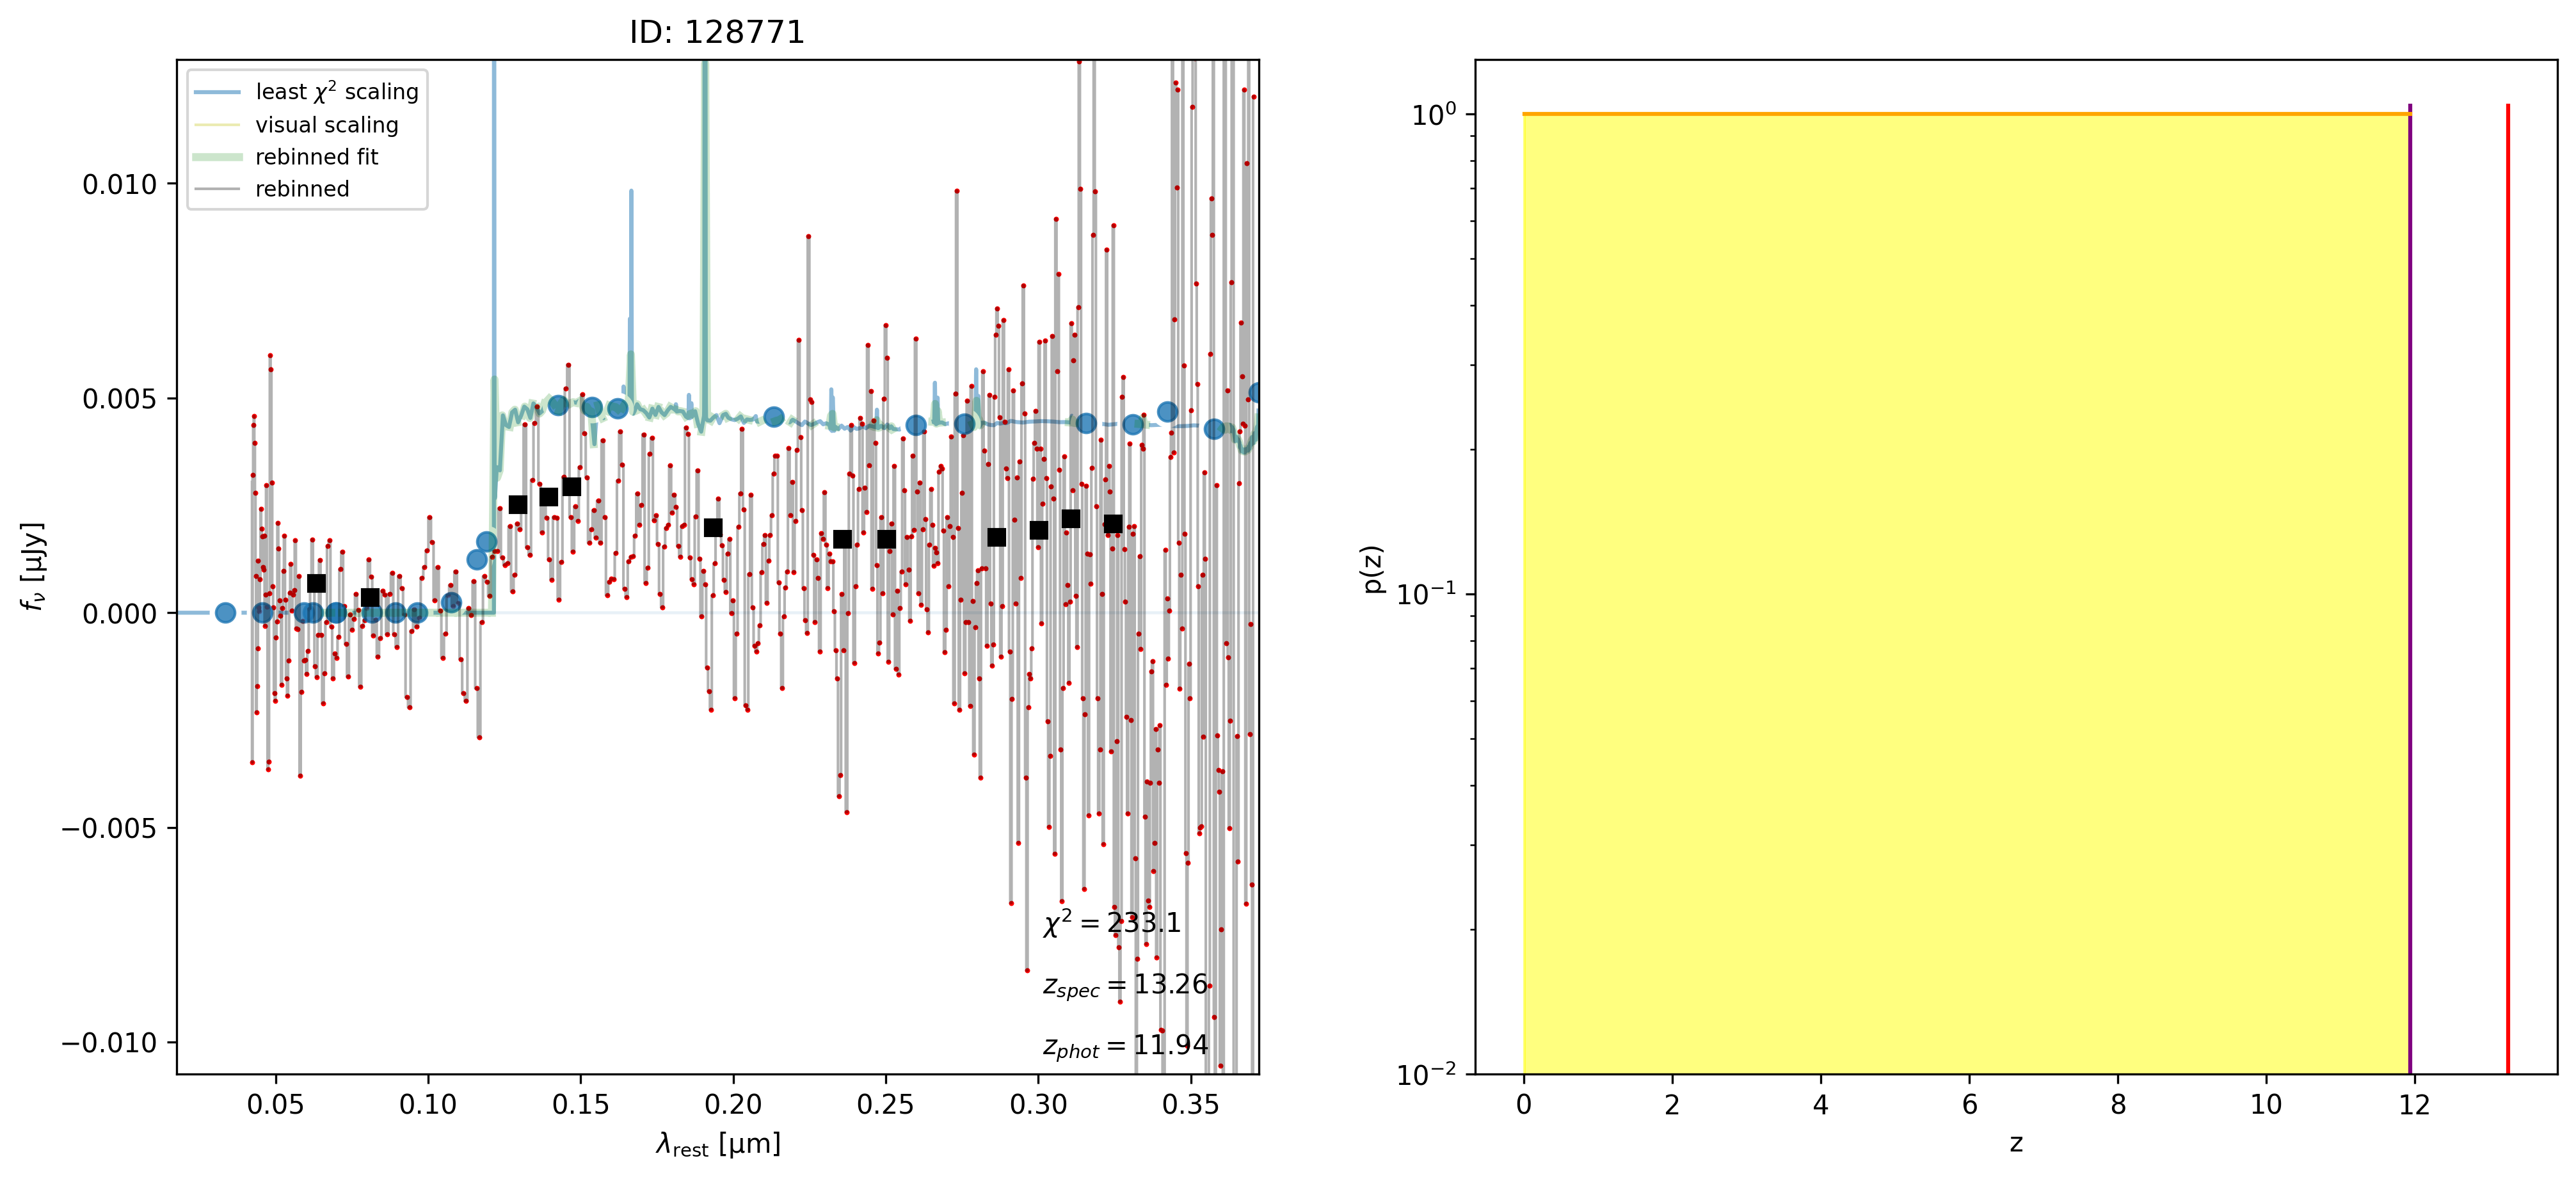

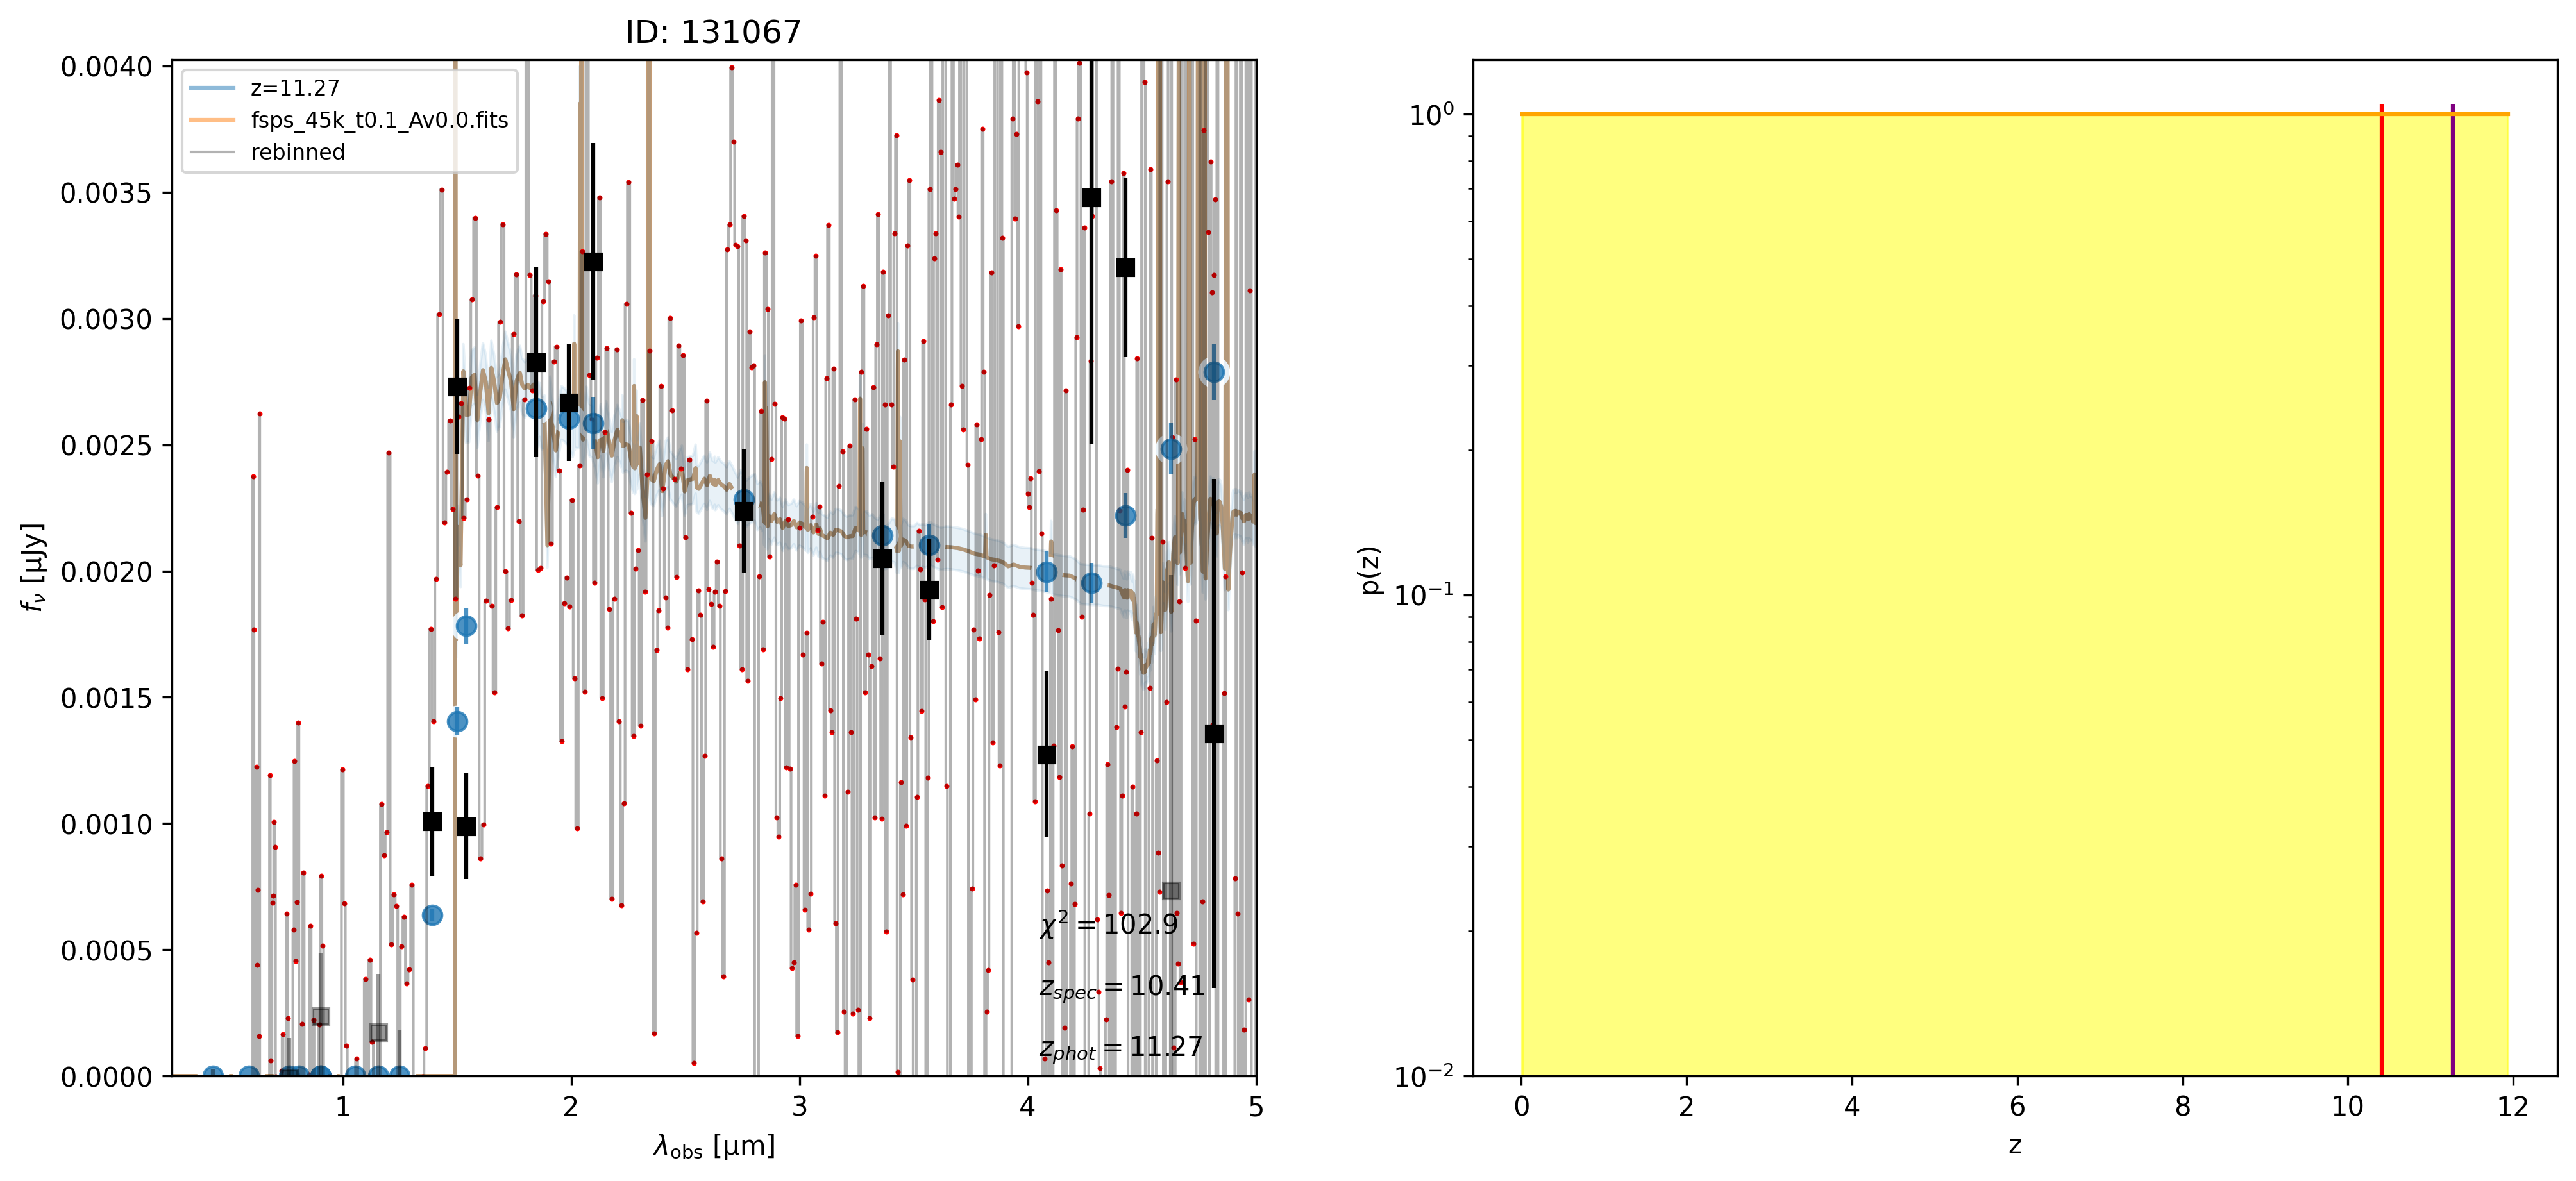

/home/t/miniconda3/envs/eazy39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/t/miniconda3/envs/eazy39/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


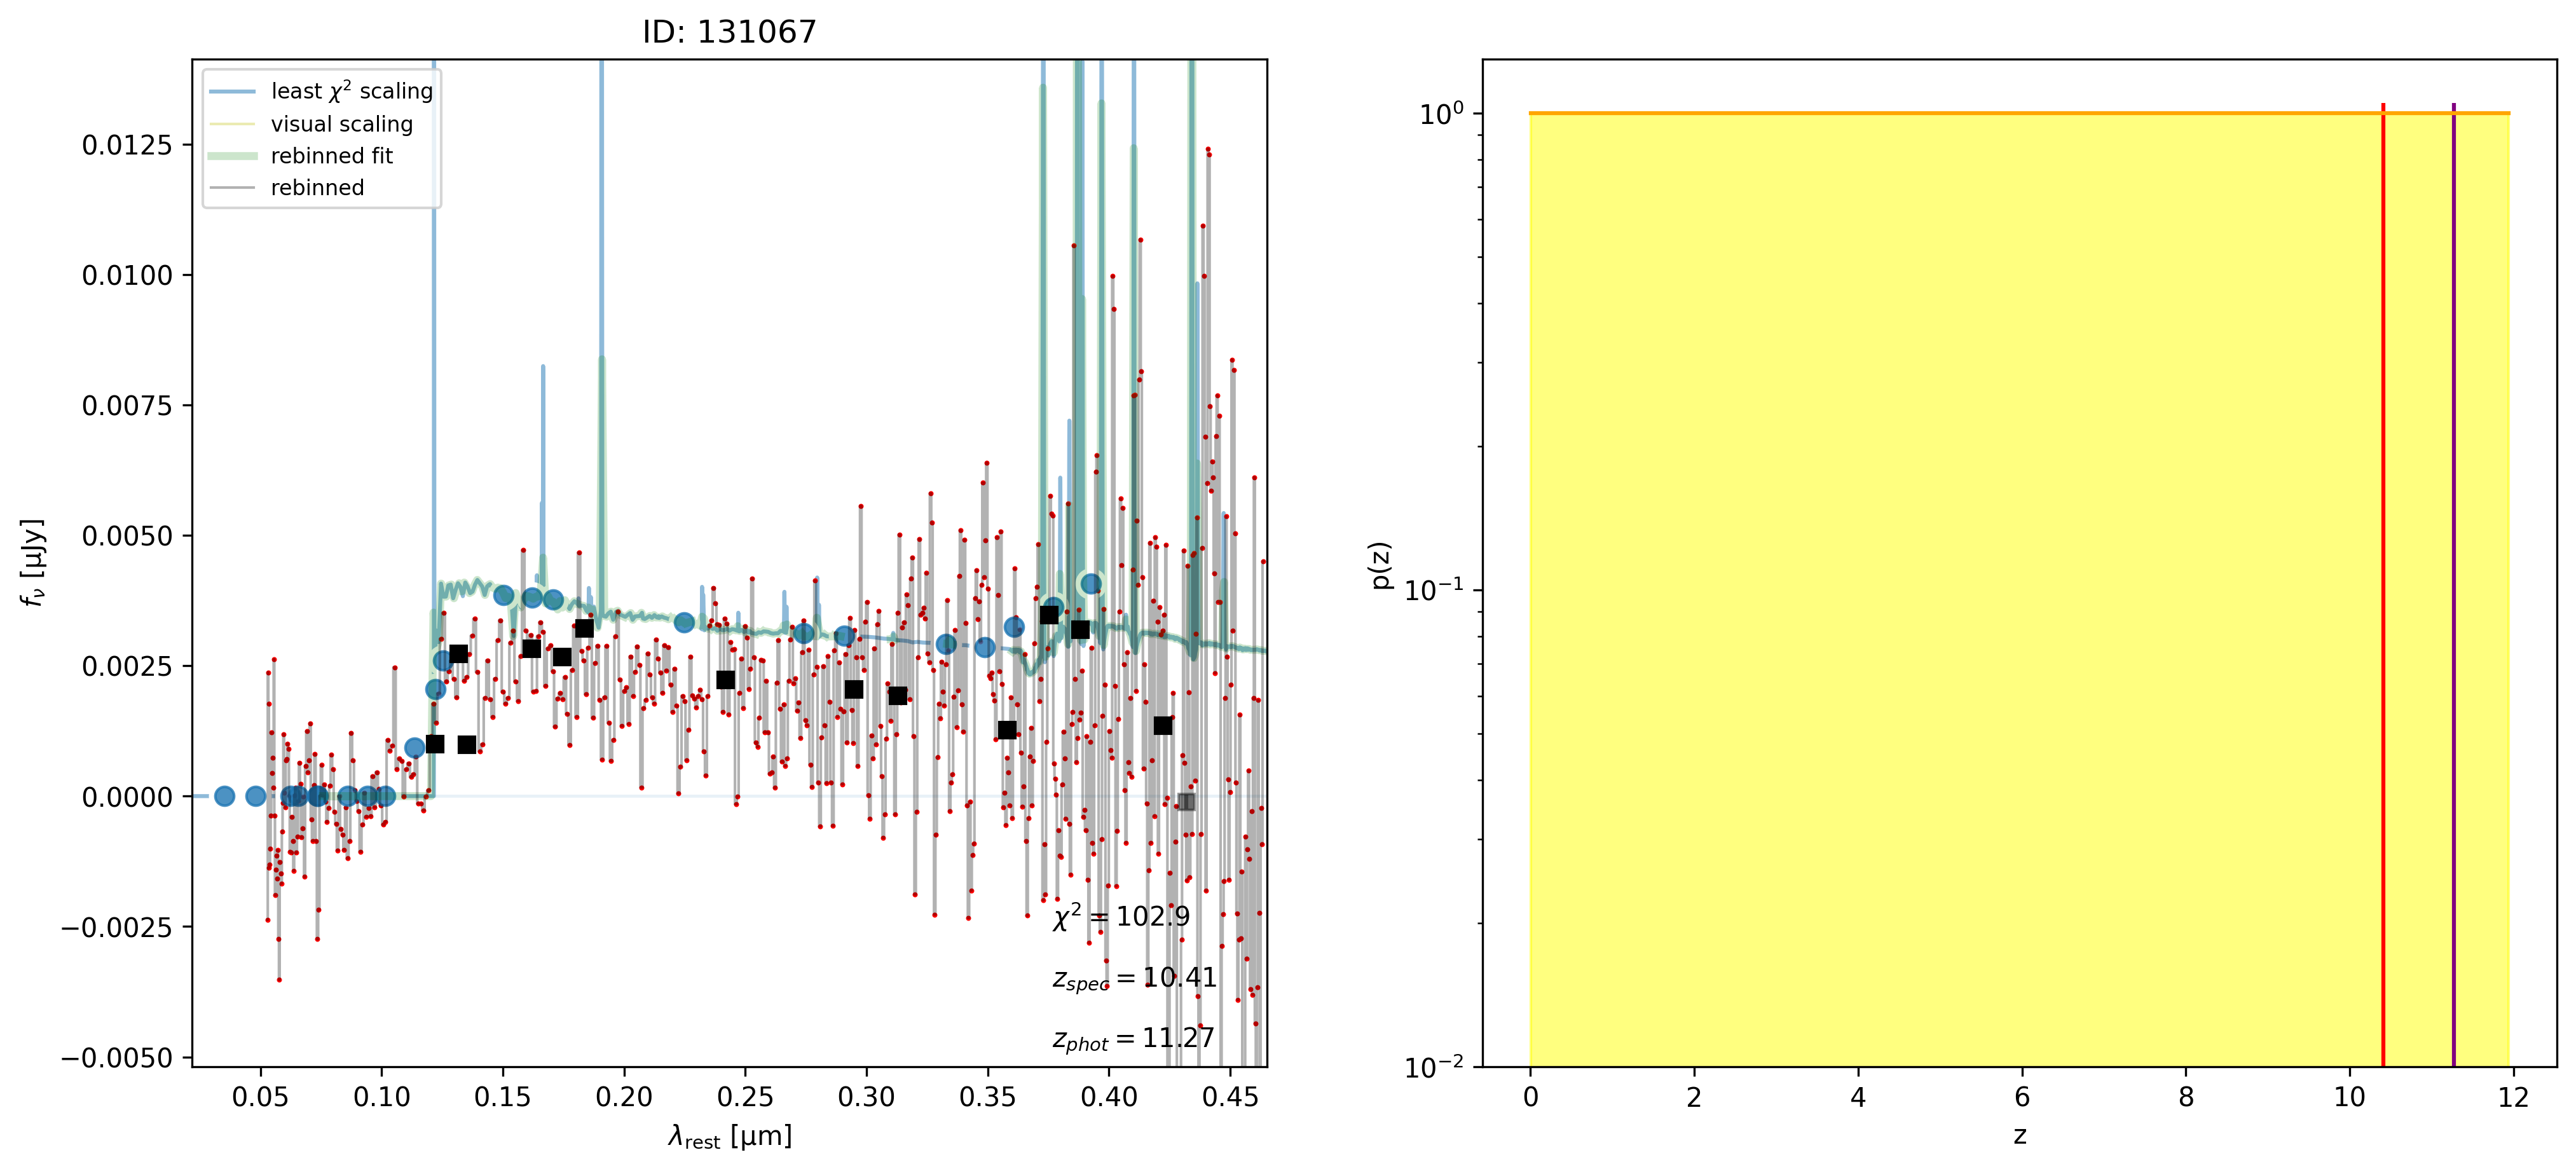

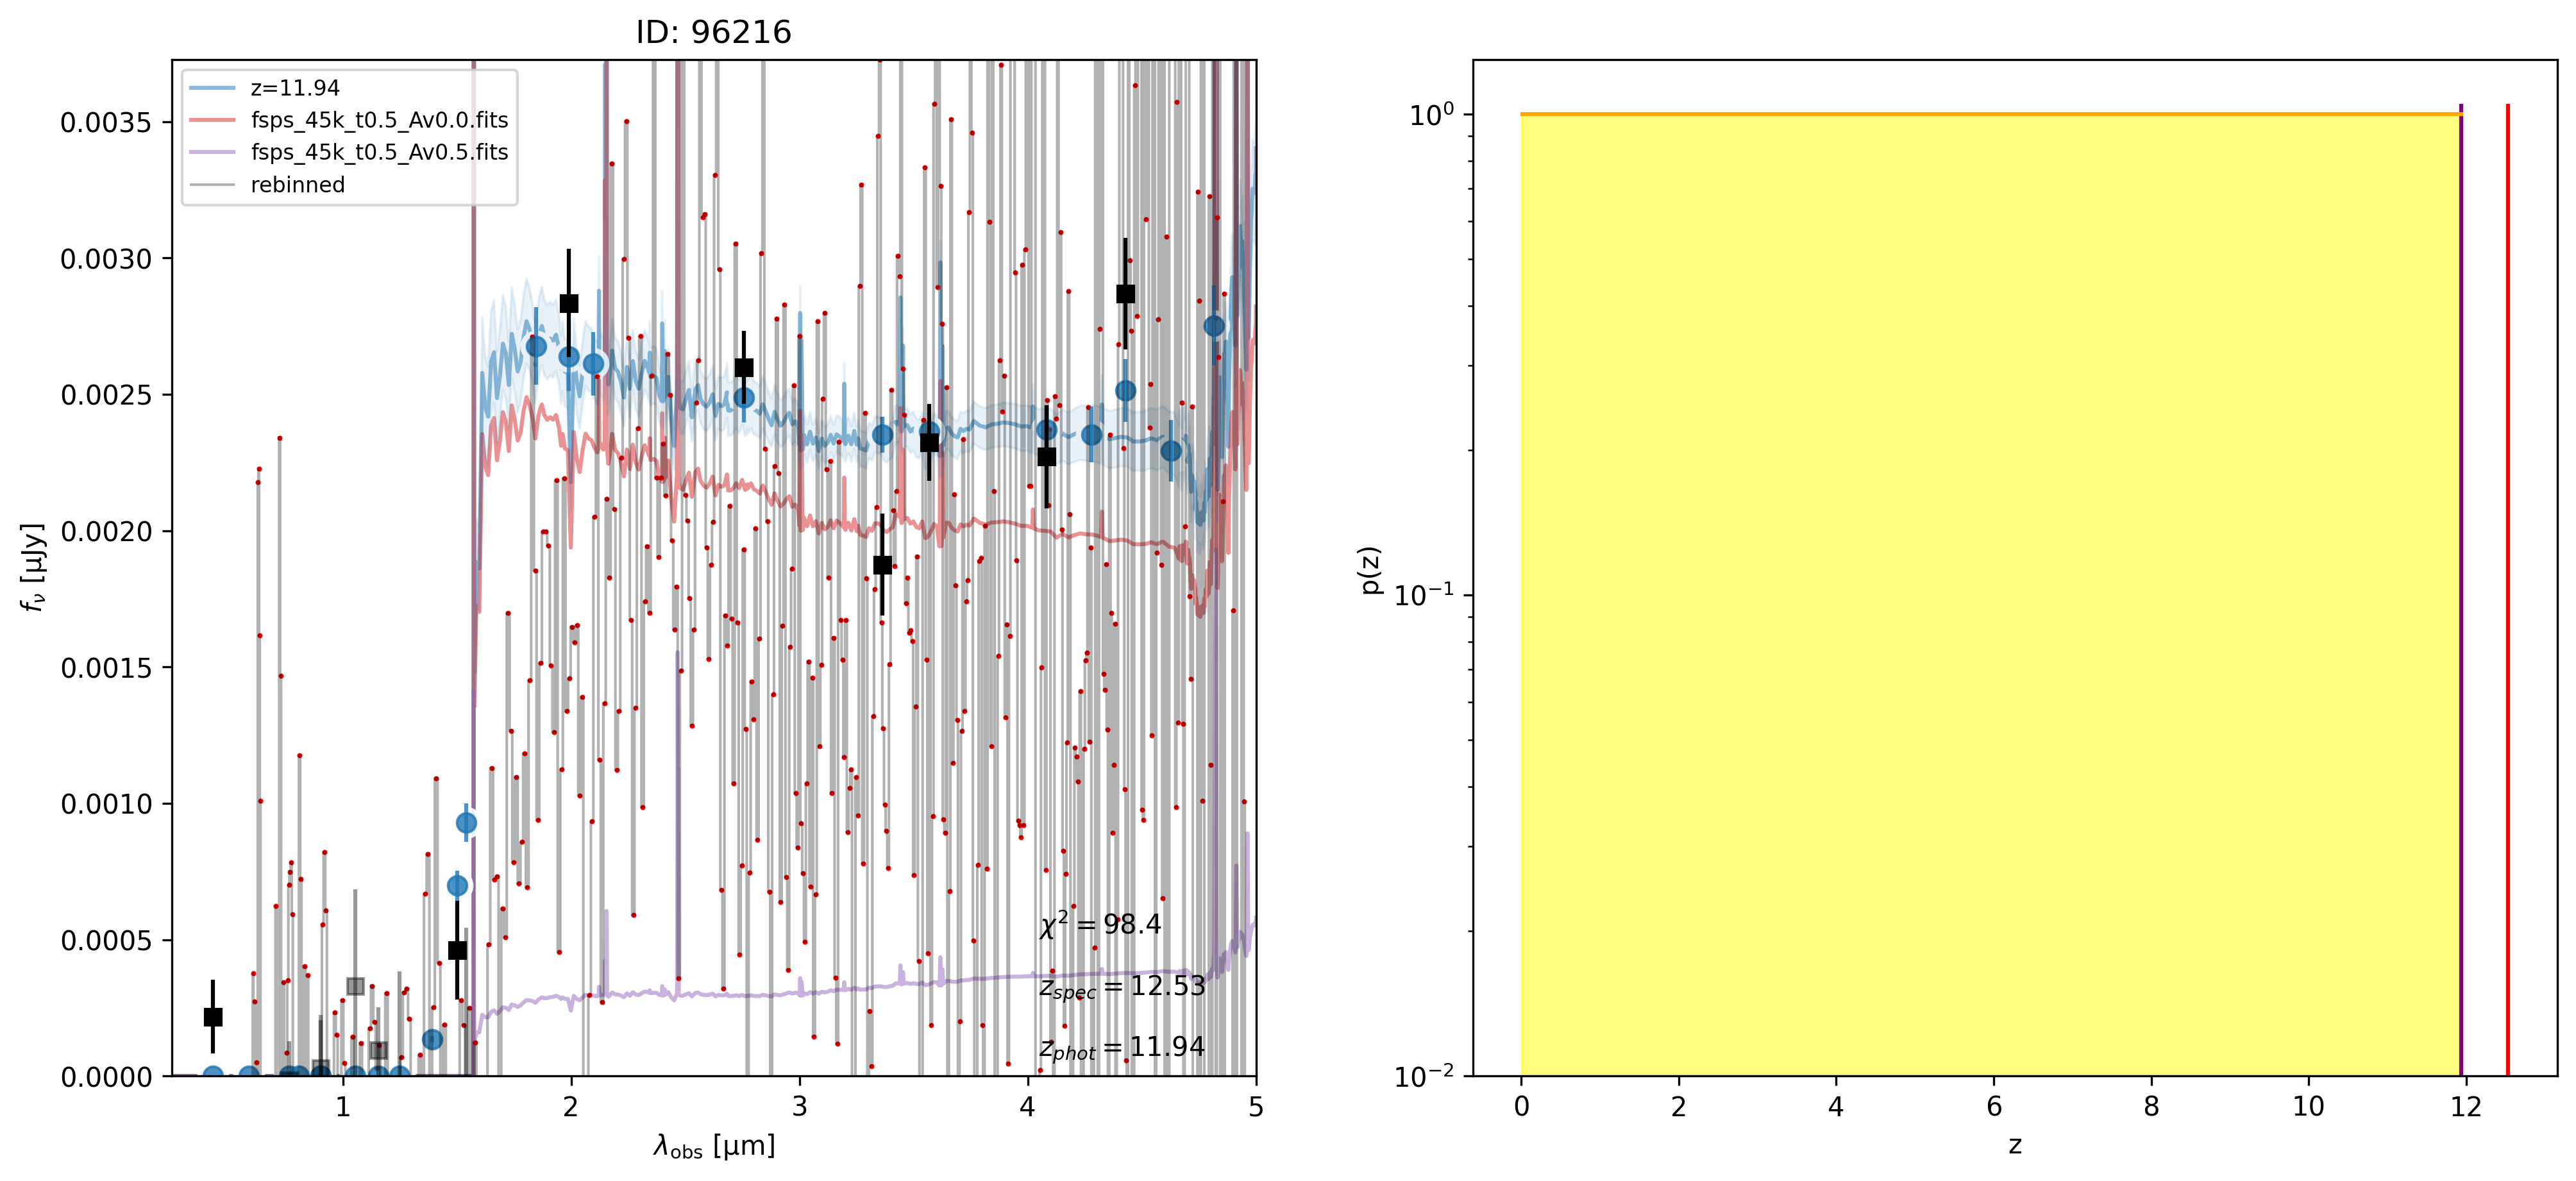

/home/t/miniconda3/envs/eazy39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/t/miniconda3/envs/eazy39/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


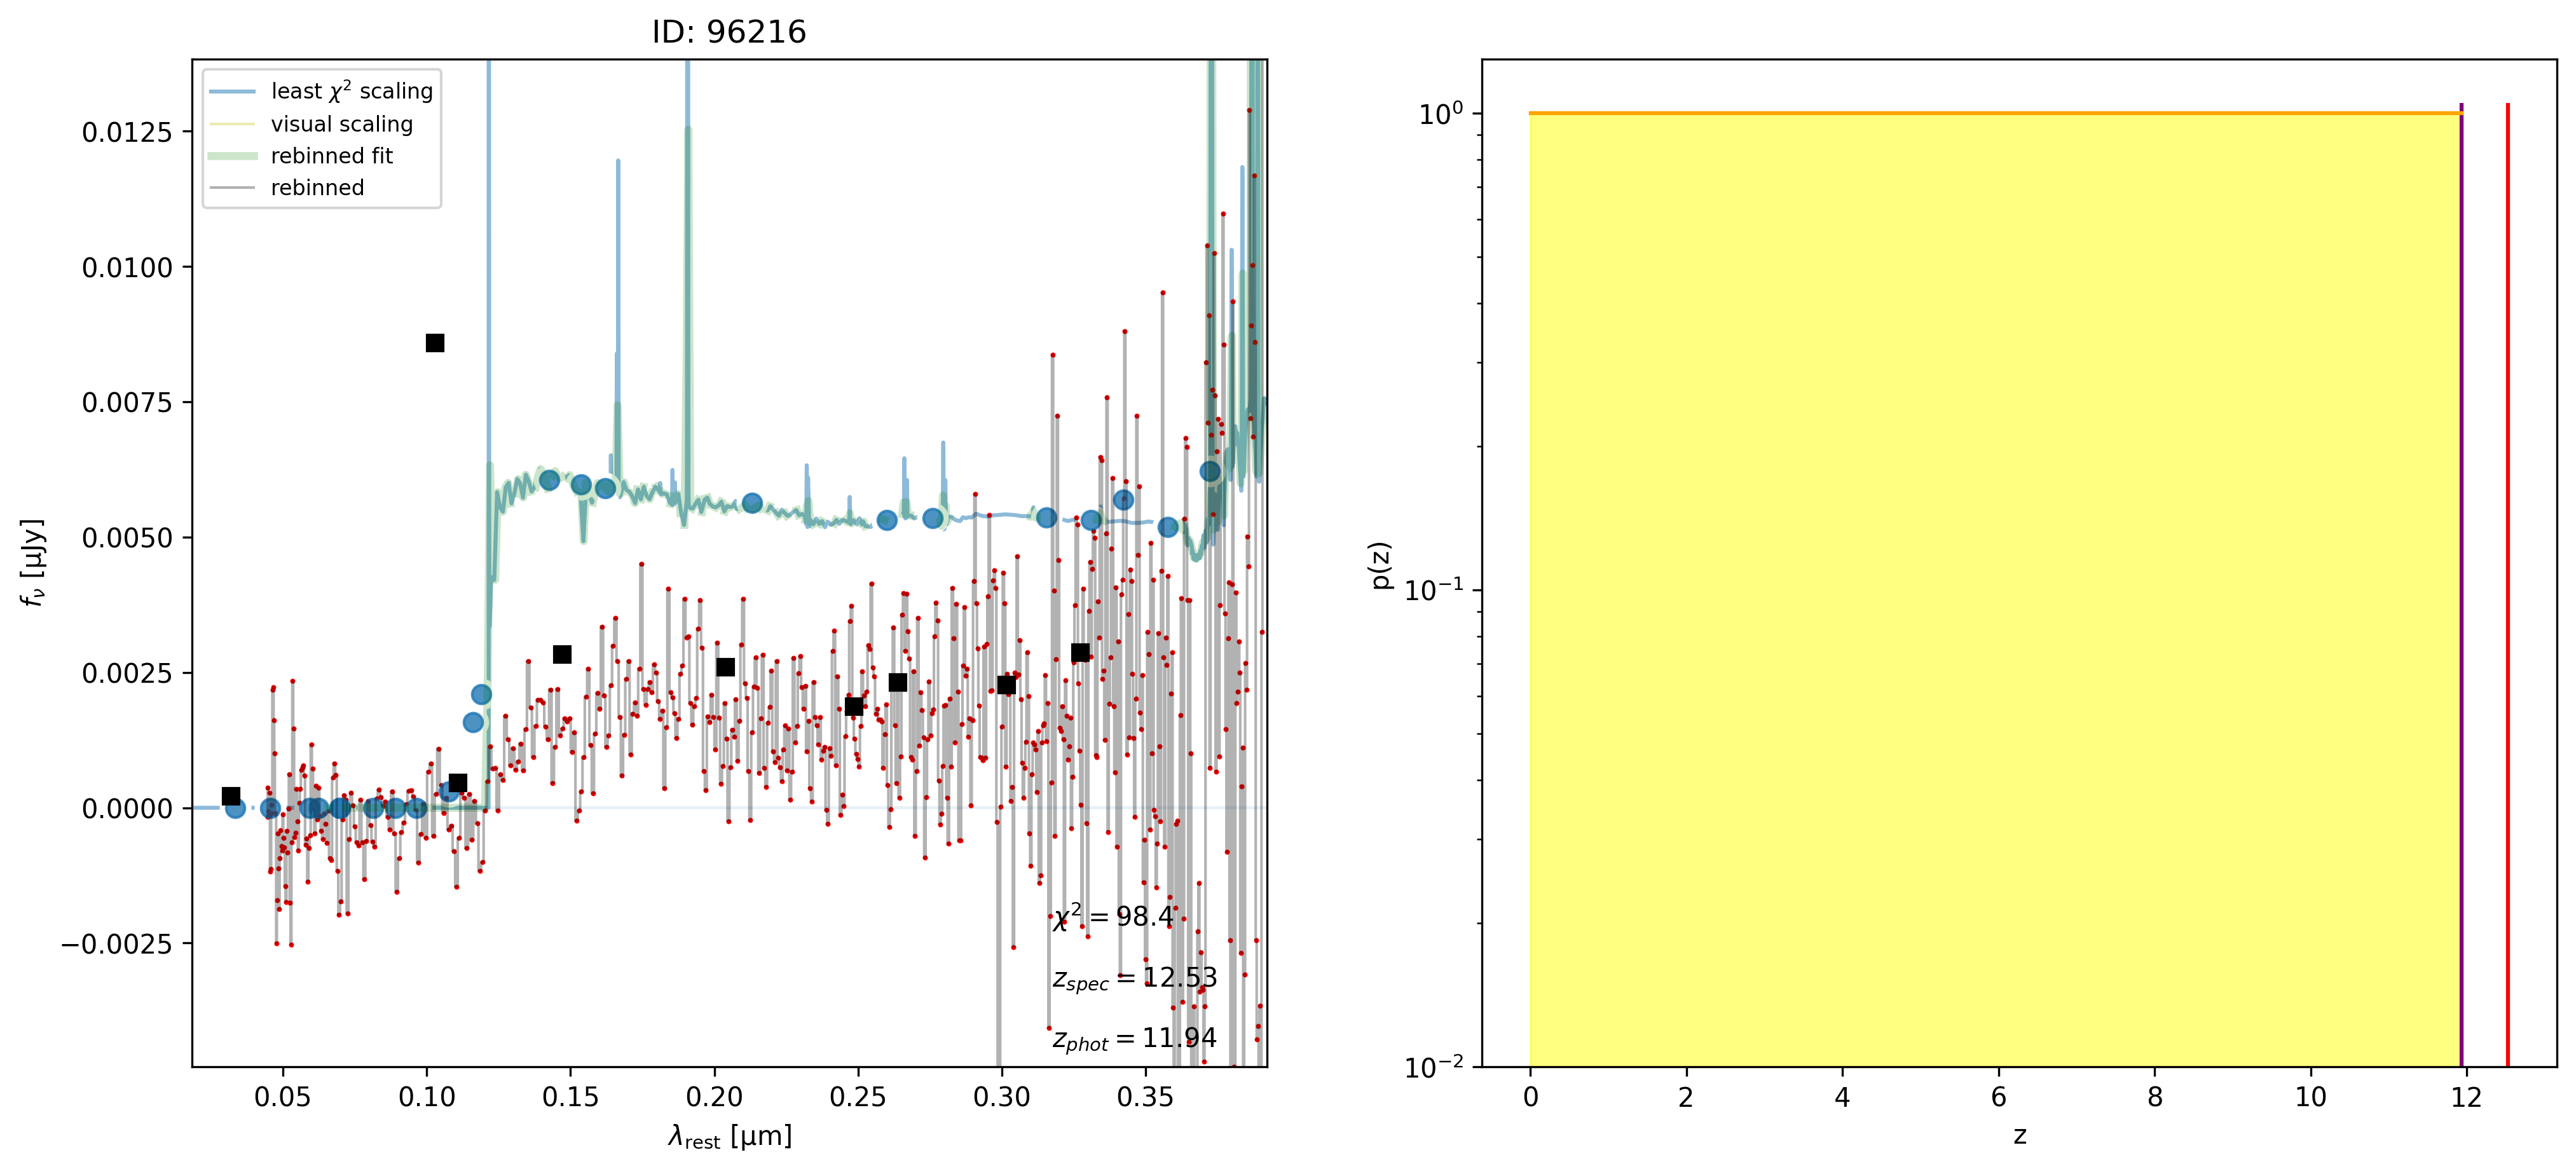

In [50]:
doObsPlot = True
doLocPlot = True   

# get spec for current obj
print("Objects: " , spec_data.keys())
#objids = [2651, 3968, 7507]
objids = list(spec_data.keys())
#get z_phoy_chi2 from df
z_phot_chi2 = df['z_phot_chi2'][df['ID_spec'].isin(objids)].values
#sort objids by z_phot_chi2
chi2_sort = np.argsort(z_phot_chi2)[::-1]
objids = np.array(objids)[chi2_sort]
objids = objids[:200]
for i,objid in enumerate(objids):
    x = spec_data[objid][0]
    y = spec_data[objid][1]
    ye = spec_data[objid][2]
    xbin, ybin, yebin = x, y, ye
    #rebin every n points by average
    n = 1#4
    xbin = np.array([np.mean(xbin[i:i+n]) for i in range(0, len(xbin), n)])
    ybin = np.array([np.mean(ybin[i:i+n]) for i in range(0, len(ybin), n)])
    yebin = np.array([np.sqrt(sum(yebin[i:i+n]**2)) for i in range(0, len(yebin), n)])

    #xbin, ybin, yebin = rebin_spec(x, y, ye, xlo=x.min(), xhi=x.max(), bw=0.005)
    id_cat = df['ID'][df['ID_spec'].isin([objid])].values

    # get cur obj id and z
    idx_cat = np.isin(zbest['ID'].data, id_cat)
    try:
        z_phot = zbest['z_phot'][idx_cat][0]
        z_phot_e = zbest['z_phot_risk'][idx_cat][0]#!not sure if this is the right error
        z_spec = df['z_spec'][df['ID_spec'].isin([objid])].values[0]
    except:
        continue
    chi2_fit = z_phot_chi2[chi2_sort][i]
    """if abs(z_phot - z_spec) < 0.1 or np.isnan(z_spec):
        continue"""
    """if abs(z_spec/z_phot) > 0.9 or abs(z_spec/z_phot) < 0.7 or z_spec < 5:
        continue"""
    if z_spec < 8 or (abs(z_spec/z_phot) > 0.96 and abs(z_spec/z_phot) < 1.04):
        continue


    #=== plot the data
    if doObsPlot:
        fig, axs = plt.subplots(1, 2, figsize=(16, 7), dpi=300)
        axs = axs.flatten()
        axs[0].set_xlabel(r'$\lambda_{\rm obs}~[{\rm \mu m}]$')
        axs[0].set_ylabel(r'$f_{\nu}~{\rm [\mu Jy]}$')
        #ax.set_xlim(0.2, 6.0)
        #ax.set_ylim(-0.001, 0.01)

        fig, data = pz.show_fit(id=id_cat, add_label=True, axes=axs,
                                show_components=True,
                                zshow=z_phot,
                                xlim=[0.1, 10.0], 
                                showpz=True, logpz=True, zr=[0, 12],
                                show_missing=True,
                                show_stars=False, snr_thresh=1.0,
                                show_fnu=True)#maglim=[])

        axs[0].set_xlim(0.25, 5)
        axs[0].set_ylim(0.000, np.mean(ybin[np.invert(np.isnan(ybin))])*0.7)

        axs[0].step(xbin, ybin/4, label='rebinned', lw=1, alpha=0.3, c='k')
        xbinWidth = (max(xbin) - min(xbin)) / len(xbin)
        axs[0].scatter((xbin[1:] + xbin[:-1])/2, ybin[1:]/4, s=2.0, color='r', lw=0.5)
        #ax.errorbar((xbin[1:] + xbin[:-1])/2, ybin[1:]/4, yerr=yebin[1:]/4, fmt='none', ecolor='r', lw=0.5, capsize=0.7, capthick=0.3, alpha=0.2)

        axs[0].annotate(rf"$z_{{spec}}={z_spec:.2f}$", xy=(0.80, 0.08), 
                    xycoords='axes fraction')
        axs[0].annotate(rf"$z_{{phot}}={z_phot:.2f}$", xy=(0.80, 0.02),
                    xycoords='axes fraction')
        axs[0].annotate(rf"$\chi^2={chi2_fit:.1f}$", xy=(0.80, 0.14),
                    xycoords='axes fraction')
        axs[0].legend(loc='upper left', bbox_to_anchor=(0.0, 1.0), fontsize=8)
        axs[0].set_title(f'ID: {id_cat[0]}')
        
        axs[1].set_xlabel('z')
        axs[1].set_ylabel('p(z)')
        axs[1].set_yscale('log')
        axs[1].set_ylim(1e-2, 1.3e0)

        plt.show()

    #do a simular plot but restframe
    if doLocPlot:
        fig, axs = plt.subplots(1, 2, figsize=(16, 7), dpi=300)
        axs = axs.flatten()
        axs[0].set_xlabel(r'$\lambda_{\rm rest}~[{\rm \mu m}]$')
        axs[0].set_ylabel(r'$f_{\nu}~{\rm [\mu Jy]}$')
        #ax.set_xlim(0.2, 6.0)
        #ax.set_ylim(-0.001, 0.01)

        fig, data = pz.show_fit(id=id_cat, add_label=True, axes=axs,
                                show_components=False,
                                zshow=z_phot,
                                xlim=[0.1, 10.0], 
                                showpz=True, logpz=True, zr=[0, 12],
                                show_missing=True,
                                show_stars=False, snr_thresh=1.0,
                                show_fnu=True)#maglim=[])

        #get xy data from plot lines and convert to restframe
        x_fit = copy(axs[0].lines[3].get_xdata())#fit
        y_fit = copy(axs[0].lines[3].get_ydata())
        x_photpoints = copy(axs[0].lines[1].get_xdata())#black points
        y_photpoints = copy(axs[0].lines[1].get_ydata())
        x_fitpoints_w = copy(axs[0].collections[0].get_offsets()[:,0])#white points (under blue points)
        y_fitpoints_w = copy(axs[0].collections[0].get_offsets()[:,1])
        x_fitpoints = copy(axs[0].collections[1].get_offsets()[:,0])#blue points
        y_fitpoints = copy(axs[0].collections[1].get_offsets()[:,1])


        x_photpoints_rest, y_photpoints_rest, ye_points_rest = obs2local(x_photpoints, y_photpoints, y_photpoints*0, z_spec)#scaling of the black points
        x_fitpoints_w_rest, y_fitpoints_w_rest, ye_fitpoints_w_rest = obs2local(x_fitpoints_w, y_fitpoints_w, y_fitpoints_w*0, z_phot)#scaling of the white points
        x_fitpoints_rest, y_fitpoints_rest, ye_fitpoints_rest = obs2local(x_fitpoints, y_fitpoints, y_fitpoints*0, z_phot)#scaling of the blue points
        x_fit_rest, y_fit_rest, _ = obs2local(x_fit, y_fit, y_fit*0, z_phot)#scaling of the blue fit
        xbin, ybin, yebin = obs2local(xbin, ybin, yebin, z_spec)#scaling of the red points

        #plot y_fit_rest to match in amplitude at x=0.55
        scaling = ybin[np.argmin(np.abs(xbin-0.6))]/4/y_fit_rest[np.argmin(np.abs(x_fit_rest-0.6))]
        if scaling<0:
            print("Negative scaling!, fixing...")
            scaling = 1
        y_fit_dumbscaling = copy(y_fit_rest)*scaling
        axs[0].plot(x_fit_rest, y_fit_dumbscaling, c='y', lw=1, alpha=0.3, label='visual scaling')

        try:
            scaling = scale2MinimizeChi2([xbin, ybin], [x_fit_rest, y_fit_rest])
        except:
            plt.show()
            continue
        y_fit_rest *= scaling
        y_fitpoints_rest *= scaling
        y_fitpoints_w_rest *= scaling

        #rebin the blue fit to the xbins
        y_fit_rest_rebinned = np.array([np.mean(y_fit_rest[np.logical_and(x_fit_rest>=xbin[i], x_fit_rest<xbin[i+1])]) for i in range(len(xbin)-1)])
        x_fit_rest_rebinned = np.array([(xbin[i]+xbin[i+1])/2 for i in range(len(xbin)-1)])
        axs[0].plot(x_fit_rest_rebinned, y_fit_rest_rebinned, c='g', lw=3, alpha=0.2, label='rebinned fit')

        axs[0].lines[3].set_xdata(x_fit_rest)
        axs[0].lines[3].set_ydata(y_fit_rest)
        axs[0].lines[1].set_xdata(x_photpoints_rest)
        axs[0].lines[1].set_ydata(y_photpoints_rest)
        axs[0].collections[0].set_offsets(np.c_[x_fitpoints_w_rest, y_fitpoints_w_rest])
        #axs[0].collections[0].set_sizes(np.ones(len(x_fitpoints_rest))*10)
        axs[0].collections[1].set_offsets(np.c_[x_fitpoints_rest, y_fitpoints_rest])
        #axs[0].collections[0].set_sizes(np.ones(len(x_fitpoints_rest))*10)

        #set label for fit to r'least $\Chi^2$ scaling'
        axs[0].lines[3].set_label(r'least $\chi^2$ scaling')
        
        axs[0].set_xlim(*obs2local([0.25, 10], [0, 0], [0, 0], z_spec)[0])
        axs[0].set_xlim([axs[0].get_xlim()[0], max(xbin)])
        #set minimum of y to minimum in array under 1.5 micron
        ybin_inLim = ybin[np.invert(np.isnan(ybin))][xbin[np.invert(np.isnan(ybin))]<1.5]
        axs[0].set_ylim(
            min(0,min(ybin_inLim)/8),
            np.mean(ybin[np.invert(np.isnan(ybin))])*0.7+(1+np.std(ybin[np.invert(np.isnan(ybin))]))*0.01
            )

        axs[0].step(xbin, ybin/4, label='rebinned', lw=1, alpha=0.3, c='k')
        xbinWidth = (max(xbin) - min(xbin)) / len(xbin)
        axs[0].scatter((xbin[1:] + xbin[:-1])/2, ybin[1:]/4, s=2.0, color='r', lw=0.5)
        #ax.errorbar((xbin[1:] + xbin[:-1])/2, ybin[1:]/4, yerr=yebin[1:]/4, fmt='none', ecolor='r', lw=0.5, capsize=0.7, capthick=0.3, alpha=0.2)

        axs[0].annotate(rf"$z_{{spec}}={z_spec:.2f}$", xy=(0.80, 0.08),
                    xycoords='axes fraction')
        axs[0].annotate(rf"$z_{{phot}}={z_phot:.2f}$", xy=(0.80, 0.02),
                    xycoords='axes fraction')
        axs[0].annotate(rf"$\chi^2={chi2_fit:.1f}$", xy=(0.80, 0.14),
                    xycoords='axes fraction')
        axs[0].legend(loc='upper left', bbox_to_anchor=(0.0, 1.0), fontsize=8)
        axs[0].set_title(f'ID: {id_cat[0]}')

        axs[1].set_xlabel('z')
        axs[1].set_ylabel('p(z)')
        axs[1].set_yscale('log')
        axs[1].set_ylim(1e-2, 1.3e0)

        plt.show()

/home/t/git/DAWNSummer2023_2/catExampleErda/helper_module.py:251: RuntimeWarning: divide by zero encountered in divide
  nmad = 1.48 * np.median(dz_abs / (1 + x))
/tmp/ipykernel_11375/500080983.py:105: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figMos.show()


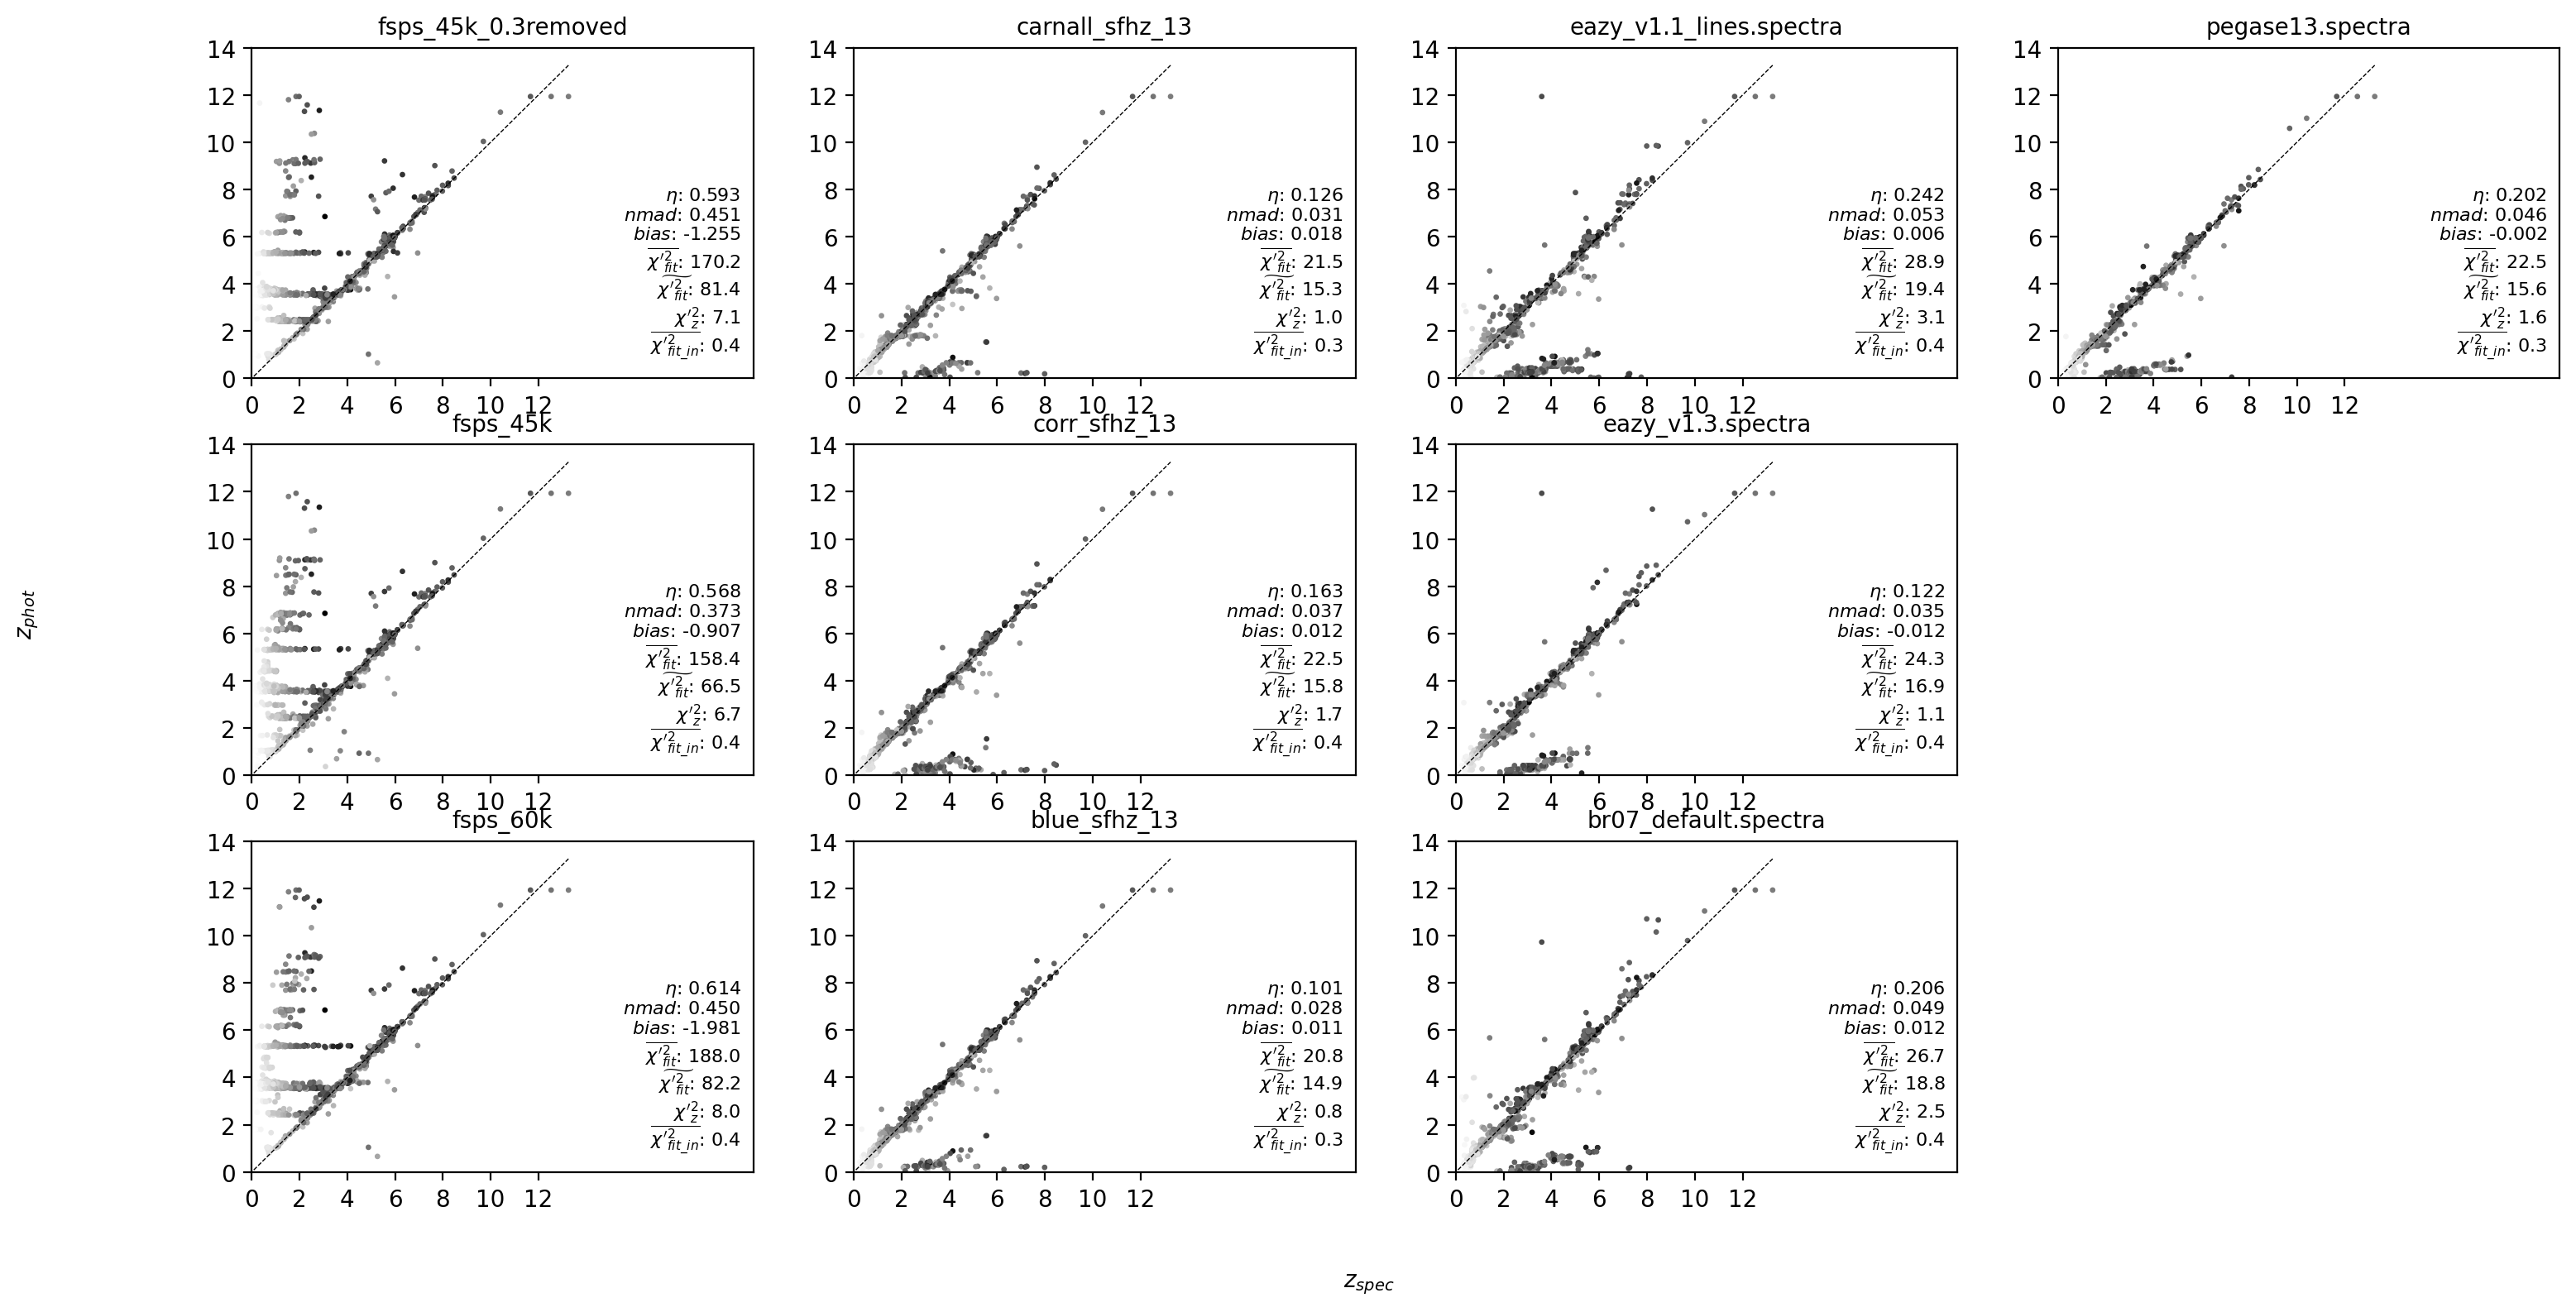

In [39]:

mosTiling = 3
mosaicLen = ceil(len(ftempl_strs) / mosTiling)
figMos, axsMos = plt.subplots(mosTiling, mosaicLen, figsize=(mosTiling*mosaicLen*1.5, 3*mosTiling), dpi=200)
#transpose and flatten
axsMos = axsMos.T
axsMos = axsMos.flatten()

for i, ftempl in enumerate(ftempl_strs):

    outpath = outpaths.format(ftempl=ftempl, runTime=runTime)
    tbl = Table.read(outpath)
    names = [name for name in tbl.colnames if len(tbl[name].shape) <= 1]
    df_props = tbl[names].to_pandas()

    #find light intensities
    ids = df_props['id'].values
    filtTab = Table.read(inpath, hdu=4)
    #get values ending with "CIRC1"
    pointIDs = filtTab['ID']
    filtTab = filtTab[[f for f in filtTab.colnames if f.endswith('CIRC1')]]
    #get dictionary version of table
    filtTab = filtTab.to_pandas()
    keys = filtTab.keys()
    fluxes = np.array([np.array(filtTab[key]) for key in keys]).T
    pointIntensities = np.sum(fluxes, axis=1)

    #clear up bad ids and make simular sort
    for j,id in list(enumerate(ids))[::-1]:
        if id not in df_props['id'].values:
            pointIntensities = np.delete(pointIntensities, j)
            ids = np.delete(ids, j)
    #sort pointIntensities and ids to match df_props
    pointIntensities = pointIntensities[np.argsort(ids)]
    ids = np.sort(ids)
    antiSort = np.argsort(df_props['id'].values)
    sort = np.argsort(antiSort)
    pointIntensities = pointIntensities[sort]
    ids = ids[sort]

    mask_cur = (df_props['z_spec'] > 0) & (~df_props['z_phot'].isna())
    x = df_props['z_spec']
    y = df_props['z_phot']
    above = y > x + (1 + x) * 0.15 # outliers
    below = y < x - (1 + x) * 0.15
    outlier = above | below
    mask_in = mask_cur & (~outlier)
    x = x.values[mask_cur]
    y = y.values[mask_cur]
    #mask_out = mask_cur & outlier
    chi2_fit = df_props['z_phot_chi2'].values[mask_cur]/len(filtTab.keys())#!new
    avgchi2_fit = np.mean(chi2_fit)
    medchi2_fit = np.median(chi2_fit)
    
    avgchi2_fit_in = df_props['z_phot_chi2'].values[mask_in]/len(x)#!new
    c = np.log10(pointIntensities[mask_cur])*((x/(1+x))**2)#!quilitative reshift scaling

    #calculate chi2 with linear regression of x and y
    chi2 = np.sum((y - x)**2/1)/len(x)#/len(x)#!dunno what to put for sigma

    xmin, xmax = np.c_[[x, y]].min(), np.c_[[x, y]].max()

    #ax.hexbin(x1, x2, gridsize=100, cmap='Greys', bins='log',
    #          mincnt=1, edgecolors='none', 
    #          extent=[xmin, xmax, xmin, xmax])
    axsMos[i].scatter(x, y, s=2.0, c=c, cmap='Greys')
    axsMos[i].plot([xmin, xmax], [xmin, xmax], c='k', ls='--', lw=0.5)
    
    dict_stat = hmod.phot_spec_zs_stats(y, x)

    #annotate in bottom right
    annotAnchor = np.array((1.025, 0.6))
    axsMos[i].set_title(f'{ftempl}', fontsize=10)
    ay = 0
    for j, (k, val) in enumerate(dict_stat.items()):
        if k == 'eta': tex = '\\'
        else: tex = ''
        axsMos[i].annotate(rf'${tex}{k}$: {val:.3f}', annotAnchor - np.array((0.05, (ay:=ay+0.06))),
                            xycoords='axes fraction', fontsize=8, ha='right')
    axsMos[i].annotate(r"$\overline{\chi' ^2_{fit}}$" + f': {avgchi2_fit:.1f}', annotAnchor - np.array((0.05, (ay:=ay+0.085))),
                        xycoords='axes fraction', fontsize=8, ha='right')
    axsMos[i].annotate(r"$\widetilde{\chi' ^2_{fit}}$" + f': {medchi2_fit:.1f}', annotAnchor - np.array((0.05, (ay:=ay+0.085))),
                        xycoords='axes fraction', fontsize=8, ha='right')
    axsMos[i].annotate(r"$\chi' ^2_z$" + f': {chi2:.1f}', annotAnchor - np.array((0.05, (ay:=ay+0.085))),
                        xycoords='axes fraction', fontsize=8, ha='right')
    axsMos[i].annotate(r"$\overline{\chi' ^2_{fit\_in}}$" + f': {np.mean(avgchi2_fit_in):.1f}', annotAnchor - np.array((0.05, (ay:=ay+0.085))),
                        xycoords='axes fraction', fontsize=8, ha='right')


    axsMos[i].set_xlim(0,14*1.5)
    axsMos[i].set_ylim(0,14)

    #set same ticks on x as y
    axsMos[i].set_xticks(axsMos[i].get_yticks()[:-1])

if len(ftempl_strs) % 3 != 0:
    axsMos[-1].axis('off')
if len(ftempl_strs) % 3 == 1:
    axsMos[-2].axis('off')

#axis label
figMos.text(0.5, 0.05, '$z_{spec}$', ha='center', va='center')
figMos.text(0.05, 0.5, '$z_{phot}$', ha='center', va='center', rotation='vertical')

figMos.savefig('./docs/figures/zs_mosaic.png', dpi=200, bbox_inches='tight')
figMos.show()

(array([  0.,   0.,   5.,  10.,   9.,  13.,  15.,  13.,  21.,  40.,  30.,
         26.,  34.,  38.,  58.,  47.,  51.,  34.,  23.,  25.,  29.,  23.,
         36.,  19.,  18.,  17.,   9.,  12.,   7.,  11.,  17.,   4.,   9.,
          6.,   4.,   0.,   6.,   6.,   5.,   5.,   8.,   9.,   2.,  11.,
          3.,   0.,   6.,   4.,   6.,   4.,   1.,   1.,   4.,   4.,   8.,
          3.,   3.,   6.,   2.,   4.,   5.,   4.,   5.,   6.,   4.,   3.,
          9.,   3.,   1.,   3.,   3.,   6.,   7.,   7.,   4.,   9.,   7.,
         10.,  13.,  23.,  29.,  42., 108., 124.,  61.,  27.,  19.,  12.,
         10.,   9.,   2.,   1.,   2.,   1.,   0.,   2.,   0.,   1.,   0.,
          3.]),
 array([0.   , 0.012, 0.024, 0.036, 0.048, 0.06 , 0.072, 0.084, 0.096,
        0.108, 0.12 , 0.132, 0.144, 0.156, 0.168, 0.18 , 0.192, 0.204,
        0.216, 0.228, 0.24 , 0.252, 0.264, 0.276, 0.288, 0.3  , 0.312,
        0.324, 0.336, 0.348, 0.36 , 0.372, 0.384, 0.396, 0.408, 0.42 ,
        0.432, 0.444, 0.456, 0.468

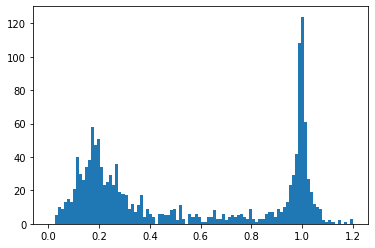

In [40]:
tab = Table.read(f'eazy-output/fsps_60k_{runTime}/gds_jades_eazy.zout.fits')
#diff = np.abs(tab['z_spec'].data - tab['z_phot'].data) / tab['z_spec'].data
diff = np.abs(tab['z_spec'].data / tab['z_phot'].data)
plt.hist(diff, bins=100, range=[0,1.2])

### Compare photometry

In [41]:
# catalog paths
cat_name = 'gds_jades_eazy'
cat_path = f'./data/{cat_name}.fits'
keys_id = ['ID id', 'RA ra', 'DEC dec', 'z_spec z_spec']

# template paths
out_names = [".".join(f.split('/')[-1].split('.')[:-1]) for f in templ_paths]
out_paths = [f"eazy-output/{f}_{runTime}" for f in out_names]
paths = np.array(out_paths)

# iterate over tempalte sets
masses = {}
for i, opath in enumerate(out_paths):
    fn = out_names[i]
    fname = f"{cat_name}.zout.fits"
    fpath = os.path.join(opath, fname)
    mass = np.log10(Table.read(fpath)['mass'].data)
    masses[fn] = mass

/tmp/ipykernel_11375/3467541305.py:17: RuntimeWarning: divide by zero encountered in log10
  mass = np.log10(Table.read(fpath)['mass'].data)
/tmp/ipykernel_11375/3467541305.py:17: RuntimeWarning: invalid value encountered in log10
  mass = np.log10(Table.read(fpath)['mass'].data)


In [42]:
mass

array([nan, nan, nan, ..., nan, nan, nan])

### Compare redshifts